# EU Parliament API

https://data.europarl.europa.eu/en/developer-corner/opendata-api

# Libraries

In [179]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from lxml import etree
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
from textblob import TextBlob
#python -m textblob.download_corpora

# **TASK 1**

## Section 1: GET all MEPS

In [57]:
def fetch_current_meps():
    url = "https://data.europarl.europa.eu/api/v2/meps/show-current"
    params = {
        "format": "application/ld+json",
        "offset": 0
    }
    headers = {"Accept": "application/ld+json"}
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    data = response.json()
    return data["data"]

def extract_fields(meps_data):

    rows = []
    for mep in meps_data:
        rows.append({
            "identifier": mep.get("identifier"),
            "id": mep.get("id"),
            "familyName": mep.get("familyName"),
            "givenName": mep.get("givenName"),
            "political_group": mep.get("api:political-group"),
        })
    return rows


meps_data = fetch_current_meps()
meps_list = extract_fields(meps_data)
df_meps = pd.DataFrame(meps_list)
print(df_meps.head(10))
print(len(df_meps)) #719 seats
df_meps.to_csv('meps.csv', index=False)

  identifier             id           familyName      givenName  \
0     257073  person/257073            Bocheński        Tobiasz   
1     257256  person/257256              Kabilov          Taner   
2      99945   person/99945               Düpont           Lena   
3     204333  person/204333               De Meo      Salvatore   
4      97236   person/97236            Toussaint          Marie   
5     197462  person/197462            Marquardt           Erik   
6     257040  person/257040  Pascual de la Parte        Nicolás   
7      96811   person/96811     Estaràs Ferragut           Rosa   
8     257117  person/257117               Axinia  Adrian-George   
9     118949  person/118949              Kovařík         Ondřej   

  political_group  
0             ECR  
1              NI  
2             PPE  
3             PPE  
4       Verts/ALE  
5       Verts/ALE  
6             PPE  
7             PPE  
8             ECR  
9             PfE  
719


## Section 2: Get all speeches of a particular date range

The 10th EU Parliament began on the 16th of July. The last avalaible report is the 3rd of April. 

https://www.europarl.europa.eu/news/en/press-room/20240710IPR22804/the-european-parliament-begins-its-tenth-term

Since there is only a record limit of 10 000, date auto-chunking is used. The idea is to split 10th EU Parliament date range into smaller periods that give less than 10 000 records. Additionally, sleep parameter between requests allows to avoid cap in the number of requests in 5 min. 

In [3]:
BASE_URL = "https://data.europarl.europa.eu/api/v2/speeches"

def fetch_page(params):
    resp = requests.get(BASE_URL, params=params, headers={"accept": "application/ld+json"})
    resp.raise_for_status()
    data = resp.json()
    return data["data"], data["meta"]["total"]

def extract_fields(activity):
    activity_id = activity.get("activity_id", None)
    label_data = activity.get("activity_label", {})
    activity_label_en = label_data.get("en", None)
    participation = activity.get("had_participation", {})
    participation_type = participation.get("type", None)
    participant_list = participation.get("had_participant_person", [])
    participant_person = participant_list[0] if participant_list else None

    return {
        "activity_id": activity_id,
        "activity_label_en": activity_label_en,
        "participation_type": participation_type,
        "participant_person": participant_person,
    }

#chunks for auto-splitting and exracting the activities (ignore 10,000 rows total cap)
def daterange_by_month(start_date, end_date):
    current = start_date
    while current <= end_date:
        next_month = current + relativedelta(months=1)
        yield current, min(next_month - timedelta(days=1), end_date)
        current = next_month

#define range
start_date = datetime.strptime("2024-07-16", "%Y-%m-%d")
end_date = datetime.strptime("2025-04-03", "%Y-%m-%d")

#parameters
BASE_PARAMS = {
    "parliamentary-term": "10",
    "activity-type": "PLENARY_DEBATE_SPEECH",
    "search-language": "en",
    "language": "en",
    "format": "application/ld+json",
    "offset": 0,
    "limit": 50,
    "sort-by": "sitting-date:asc" #sort by date
}

all_rows = []

#loop over monthly ranges
for chunk_start, chunk_end in daterange_by_month(start_date, end_date):
    print(f"Fetching from {chunk_start.date()} to {chunk_end.date()}")

    offset = 0
    while True:
        params = BASE_PARAMS.copy()
        params["sitting-date"] = chunk_start.strftime("%Y-%m-%d") #add auto-defined date chunks
        params["sitting-date-end"] = chunk_end.strftime("%Y-%m-%d")
        params["offset"] = offset

        try:
            page_data, total = fetch_page(params)
        except Exception as e:
            print("No activities in this period")
            break

        if not page_data:
            break

        for activity in page_data:
            all_rows.append(extract_fields(activity))

        offset += BASE_PARAMS["limit"]
        if offset >= total:
            break

        time.sleep(1)  #stay under 500 requests/5min

df = pd.DataFrame(all_rows)
print(df.head(10))
print("Total rows fetched:", len(df))

Fetching from 2024-07-16 to 2024-08-15
Fetching from 2024-08-16 to 2024-09-15
No activities in this period
Fetching from 2024-09-16 to 2024-10-15
Fetching from 2024-10-16 to 2024-11-15
Fetching from 2024-11-16 to 2024-12-15
Fetching from 2024-12-16 to 2025-01-15
Fetching from 2025-01-16 to 2025-02-15
Fetching from 2025-02-16 to 2025-03-15
Fetching from 2025-03-16 to 2025-04-03
                      activity_id  \
0  MTG-PL-2024-07-16-OTH-10040000   
1  MTG-PL-2024-07-16-OTH-10060000   
2  MTG-PL-2024-07-16-OTH-10090000   
3  MTG-PL-2024-07-16-OTH-10110000   
4  MTG-PL-2024-07-16-OTH-10120000   
5  MTG-PL-2024-07-16-OTH-10120001   
6  MTG-PL-2024-07-16-OTH-10130000   
7  MTG-PL-2024-07-16-OTH-10140000   
8  MTG-PL-2024-07-16-OTH-10160000   
9  MTG-PL-2024-07-16-OTH-10180000   

                                   activity_label_en participation_type  \
0  Opening of the sitting (first sitting of the n...      Participation   
1                        Verification of credentials      Part

In [4]:
df.to_csv("activities_raw.csv", index=False)
df.tail(10)

,activity_id,activity_label_en,participation_type,participant_person
12265,MTG-PL-2025-04-03-OTH-2017020833270,Dates of the next part-session,Participation,person/125042
12266,MTG-PL-2025-04-03-OTH-2017020625674,European Action Plan on Rare Diseases (debate),Participation,person/197528
12267,MTG-PL-2025-04-03-OTH-2017020625682,European Action Plan on Rare Diseases (debate),Participation,person/257063
12268,MTG-PL-2025-04-03-OTH-2017020625690,European Action Plan on Rare Diseases (debate),Participation,person/256842
12269,MTG-PL-2025-04-03-OTH-2017020625709,European Action Plan on Rare Diseases (debate),Participation,person/30482
12270,MTG-PL-2025-04-03-OTH-2017020745574,Verification of credentials,Participation,person/37312
12271,MTG-PL-2025-04-03-OTH-2017020745599,Amending Directives (EU) 2022/2464 and (EU) 20...,Participation,person/37312
12272,MTG-PL-2025-04-03-OTH-2017020745625,Approval of the minutes of the previous sitting,Participation,person/125042
12273,MTG-PL-2025-04-03-OTH-2017020833249,Health care related tourism: protecting EU pat...,Participation,person/197841
12274,MTG-PL-2025-04-03-OTH-2017020833268,Approval of the minutes of the sitting and for...,Participation,person/125042


Data requires cleaning:
- Date is obtained from activity_id
- Topic is assumed to be the same as activity_label
- Person data like name and party are joined from previously created database using person_id

In [5]:
df = pd.read_csv('activities_raw.csv')

In [7]:
date_parts = df["activity_id"].str.split('-')
df["date"] = date_parts.str[2] + "-" + date_parts.str[3] + "-" + date_parts.str[4]
df["date"] = pd.to_datetime(df["date"])
df['identifier'] = df['participant_person'].str.extract(r"/(\d+)") #only digits after slash
merged_df = pd.merge(df, df_meps, on="identifier") #merge with MEPs
merged_df['person'] = merged_df['givenName']+' '+merged_df['familyName'] #join to one
merged_df.rename(columns={'activity_label_en': 'topic', 'identifier':'person_id'}, inplace=True) #rename 
merged_df = merged_df.drop(['participation_type', 'participant_person', 'id', 'familyName', 'givenName'], axis=1) #delete unneccessary
merged_df = merged_df.iloc[:, [2, 1, 5, 3, 4, 0]] #reorder 

In [8]:
merged_df

,date,topic,person,person_id,political_group,activity_id
0,2024-07-16,Opening of the sitting (first sitting of the n...,Roberta Metsola,118859,PPE,MTG-PL-2024-07-16-OTH-10040000
1,2024-07-16,Verification of credentials,Roberta Metsola,118859,PPE,MTG-PL-2024-07-16-OTH-10060000
2,2024-07-16,Announcement of the candidates for election to...,Pina Picierno,124846,S&D,MTG-PL-2024-07-16-OTH-10090000
3,2024-07-16,Short presentations by the candidates for elec...,Pina Picierno,124846,S&D,MTG-PL-2024-07-16-OTH-10110000
4,2024-07-16,Short presentations by the candidates for elec...,Roberta Metsola,118859,PPE,MTG-PL-2024-07-16-OTH-10120000
...,...,...,...,...,...,...
11638,2025-04-03,Verification of credentials,Christel Schaldemose,37312,S&D,MTG-PL-2025-04-03-OTH-2017020745574
11639,2025-04-03,Amending Directives (EU) 2022/2464 and (EU) 20...,Christel Schaldemose,37312,S&D,MTG-PL-2025-04-03-OTH-2017020745599
11640,2025-04-03,Approval of the minutes of the previous sitting,Javi López,125042,S&D,MTG-PL-2025-04-03-OTH-2017020745625
11641,2025-04-03,Health care related tourism: protecting EU pat...,Liudas Mažylis,197841,PPE,MTG-PL-2025-04-03-OTH-2017020833249


### Why there are less rows than fetched in total? 

In [9]:
merged_df_test = pd.merge(df, df_meps, on="identifier", how="outer", indicator=True)
missing_from_meps = merged_df_test[merged_df_test["_merge"] == "left_only"]
print(missing_from_meps) #632 rows (12275 - 11643)
missing_from_meps['identifier'].unique()

                               activity_id  \
21     MTG-PL-2024-09-18-OTH-2017001405944   
22     MTG-PL-2024-09-18-OTH-2017001405949   
23     MTG-PL-2024-09-18-OTH-2017001401345   
24     MTG-PL-2024-10-09-OTH-2017002474258   
25     MTG-PL-2024-10-09-OTH-2017002474323   
...                                    ...   
12255  MTG-PL-2025-02-12-OTH-2017014905708   
12256  MTG-PL-2025-02-13-OTH-2017015288729   
12257  MTG-PL-2025-02-13-OTH-2017015183918   
12258  MTG-PL-2025-03-11-OTH-2017017656682   
12259  MTG-PL-2025-04-01-OTH-2017020375875   

                                       activity_label_en participation_type  \
21     Organised crime, a major threat to the interna...      Participation   
22     Presentation by the Council of its position on...      Participation   
23     Organised crime, a major threat to the interna...      Participation   
24                   The case of Bülent Mumay in Türkiye      Participation   
25     Protecting the EU budget and ensuring that EU

array(['101463', '103213', '105800', '108064', '110653', '111411',
       '115093', '119434', '121194', '124697', '124726', '129146',
       '186053', '188100', '190692', '193419', '197481', '197508',
       '197843', '201941', '201944', '201946', '207520', '220921',
       '220963', '227855', '230786', '230946', '232604', '23784',
       '238669', '244847', '245749', '251198', '257105', '257351',
       '260405', '263032', '263971', '263972', '263973', '263974',
       '263975', '263979', '264078', '264079', '264609', '265039',
       '266640', '266641', '266642', '28115', '28156', '28267', '28303',
       '28308', '28413', '28618', '36803', '37656', '39315', '39921',
       '4465', '72771', '99424'], dtype=object)

In [10]:
for miss_mep in missing_from_meps['identifier'].unique():
    url =f"https://data.europarl.europa.eu/api/v2/meps/{miss_mep}"
    params = {
        "format": "application/ld+json",
        "offset": 0
    }
    headers = {"Accept": "application/ld+json"}
    try:
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()
        missing_mep = response.json()
        memberships = missing_mep['data'][-1]['hasMembership']
        end_dates = []
        for membership in memberships:
            member_during = membership.get('memberDuring', {})
            end_date = member_during.get('endDate') #store the end dates of membership
            if end_date:
                end_dates.append(end_date)
        if end_dates:
            latest_end_date = max(pd.to_datetime(end_dates)) #choose the latest one
            print("Latest end date:", latest_end_date.date())
        else:
            print("No end dates found.")
    except requests.exceptions.HTTPError as http_err:
        if response.status_code == 404:
            print(f"MEP {miss_mep} not found (404 error).")
        else:
            print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")

MEP 101463 not found (404 error).
MEP 103213 not found (404 error).
MEP 105800 not found (404 error).
MEP 108064 not found (404 error).
MEP 110653 not found (404 error).
MEP 111411 not found (404 error).
MEP 115093 not found (404 error).
Latest end date: 2019-11-30
MEP 121194 not found (404 error).
Latest end date: 2018-09-04
Latest end date: 2024-11-30
MEP 129146 not found (404 error).
MEP 186053 not found (404 error).
MEP 188100 not found (404 error).
MEP 190692 not found (404 error).
Latest end date: 2024-11-30
Latest end date: 2025-03-24
Latest end date: 2024-01-11
Latest end date: 2024-11-30
MEP 201941 not found (404 error).
MEP 201944 not found (404 error).
MEP 201946 not found (404 error).
MEP 207520 not found (404 error).
MEP 220921 not found (404 error).
MEP 220963 not found (404 error).
MEP 227855 not found (404 error).
MEP 230786 not found (404 error).
MEP 230946 not found (404 error).
MEP 232604 not found (404 error).
Latest end date: 2016-05-07
MEP 238669 not found (404 er

Missing members of Parliament are either not found or not active for the search date. 

## Section 3: Get speech text for a specific activity id (speech)

In [38]:
def get_speech_details(activity_id):

    my_base_url = "https://data.europarl.europa.eu/api/v2/speeches/"

    params = {
        "search-language": "en",
        "include-output": "xml_fragment",
        "language": "en",
        "format": "application/ld+json"
    }

    url = my_base_url + activity_id

    try:
        resp = requests.get(url, params=params, headers={"accept": "application/ld+json"})
        resp.raise_for_status()
    except Exception as e:
        print(f"Request failed for {activity_id}: {e}")
        return None

    data = resp.json()
    if not data.get("data"):
        print(f"No data for {activity_id}!")
        return None

    speech_obj = data["data"][0]

    xml_fragments = speech_obj.get("api:xmlFragment", {})
    xml_str = xml_fragments.get("en", None)
    if not xml_str:
        print(f"No 'api:xmlFragment' for {activity_id} in English!")
        return None

    # Parse the XML snippet with lxml
    root = etree.fromstring(xml_str.encode("utf-8"))

    person_elems = root.xpath("//person")
    person_name = person_elems[0].text.strip() if person_elems and person_elems[0].text else None

    role_elems = root.xpath("//role")
    role_text = role_elems[0].text.strip() if role_elems and role_elems[0].text else None

    paragraphs = []
    p_elems = root.xpath("//p")
    for p in p_elems:
        paragraphs.append(p.text.strip() if p.text else "")

    return {
        "activity_id": activity_id,
        "person_name": person_name,
        "role_text": role_text,
        "paragraphs": paragraphs
    }

In [43]:
merged_df["speech_text"] = None #create column
for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Fetching speech texts"):
    activity_id = row["activity_id"]
    details = get_speech_details(activity_id)

    if details and details["paragraphs"]:
        # Join all paragraphs into one text block
        full_speech = "\n".join(details["paragraphs"])
    else:
        full_speech = None

    merged_df.at[idx, "speech_text"] = full_speech
merged_df.to_csv('processed_speeches.csv', index=False)

Fetching speech texts:  17%|████████▊                                           | 1972/11643 [25:34<2:04:17,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325005 in English!


Fetching speech texts:  17%|████████▊                                           | 1973/11643 [25:34<1:59:47,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332337 in English!


Fetching speech texts:  17%|████████▊                                           | 1974/11643 [25:35<2:01:03,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235776 in English!


Fetching speech texts:  17%|████████▊                                           | 1975/11643 [25:36<2:01:22,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235780 in English!


Fetching speech texts:  17%|████████▊                                           | 1978/11643 [25:38<1:58:08,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235820 in English!


Fetching speech texts:  17%|████████▊                                           | 1979/11643 [25:39<2:00:14,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320454 in English!


Fetching speech texts:  17%|████████▊                                           | 1980/11643 [25:40<2:04:36,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320463 in English!


Fetching speech texts:  17%|████████▊                                           | 1981/11643 [25:41<2:05:37,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320469 in English!


Fetching speech texts:  17%|████████▊                                           | 1982/11643 [25:41<2:01:56,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320477 in English!


Fetching speech texts:  17%|████████▊                                           | 1983/11643 [25:42<2:02:11,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320509 in English!


Fetching speech texts:  17%|████████▊                                           | 1986/11643 [25:44<2:01:26,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324954 in English!


Fetching speech texts:  17%|████████▊                                           | 1987/11643 [25:45<2:01:52,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324981 in English!


Fetching speech texts:  17%|████████▉                                           | 1988/11643 [25:46<2:02:20,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324997 in English!


Fetching speech texts:  17%|████████▉                                           | 1989/11643 [25:47<2:02:05,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325007 in English!


Fetching speech texts:  17%|████████▉                                           | 1990/11643 [25:47<2:02:19,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325021 in English!


Fetching speech texts:  17%|████████▉                                           | 1991/11643 [25:48<2:04:51,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325035 in English!


Fetching speech texts:  17%|████████▉                                           | 1992/11643 [25:49<2:03:13,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332263 in English!


Fetching speech texts:  17%|████████▉                                           | 1993/11643 [25:50<2:04:09,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332266 in English!


Fetching speech texts:  17%|████████▉                                           | 1994/11643 [25:50<2:00:51,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332274 in English!


Fetching speech texts:  17%|████████▉                                           | 1995/11643 [25:51<2:01:14,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332331 in English!


Fetching speech texts:  17%|████████▉                                           | 1996/11643 [25:52<2:02:08,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332343 in English!


Fetching speech texts:  17%|████████▉                                           | 1998/11643 [25:53<2:03:11,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392361 in English!


Fetching speech texts:  17%|████████▉                                           | 1999/11643 [25:54<2:03:24,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392388 in English!


Fetching speech texts:  17%|████████▉                                           | 2000/11643 [25:55<2:04:14,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392392 in English!


Fetching speech texts:  17%|████████▉                                           | 2001/11643 [25:56<2:04:03,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392409 in English!


Fetching speech texts:  17%|████████▉                                           | 2002/11643 [25:56<2:00:50,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401164 in English!


Fetching speech texts:  17%|████████▉                                           | 2003/11643 [25:57<2:01:20,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401171 in English!


Fetching speech texts:  17%|████████▉                                           | 2004/11643 [25:58<2:00:21,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401183 in English!


Fetching speech texts:  17%|████████▉                                           | 2005/11643 [25:59<2:03:17,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401214 in English!


Fetching speech texts:  17%|████████▉                                           | 2008/11643 [26:01<1:59:18,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465649 in English!


Fetching speech texts:  17%|████████▉                                           | 2009/11643 [26:02<2:01:31,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465651 in English!


Fetching speech texts:  17%|████████▉                                           | 2010/11643 [26:03<1:59:27,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465653 in English!


Fetching speech texts:  17%|████████▉                                           | 2011/11643 [26:03<2:00:17,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465675 in English!


Fetching speech texts:  17%|████████▉                                           | 2012/11643 [26:04<2:00:48,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465682 in English!


Fetching speech texts:  17%|████████▉                                           | 2013/11643 [26:05<1:58:17,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465724 in English!


Fetching speech texts:  17%|████████▉                                           | 2014/11643 [26:05<1:55:46,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474248 in English!


Fetching speech texts:  17%|█████████                                           | 2016/11643 [26:07<1:58:17,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474269 in English!


Fetching speech texts:  17%|█████████                                           | 2018/11643 [26:08<1:59:00,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235802 in English!


Fetching speech texts:  17%|█████████                                           | 2020/11643 [26:10<2:01:43,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235820 in English!


Fetching speech texts:  17%|█████████                                           | 2022/11643 [26:12<2:20:29,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235830 in English!


Fetching speech texts:  17%|█████████                                           | 2023/11643 [26:13<2:16:33,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320456 in English!


Fetching speech texts:  17%|█████████                                           | 2025/11643 [26:14<2:20:09,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320495 in English!


Fetching speech texts:  17%|█████████                                           | 2026/11643 [26:15<2:22:58,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320500 in English!


Fetching speech texts:  17%|█████████                                           | 2027/11643 [26:16<2:14:51,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324944 in English!


Fetching speech texts:  17%|█████████                                           | 2028/11643 [26:17<2:23:40,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324960 in English!


Fetching speech texts:  17%|█████████                                           | 2029/11643 [26:18<2:14:58,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325019 in English!


Fetching speech texts:  17%|█████████                                           | 2030/11643 [26:19<2:14:07,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325032 in English!


Fetching speech texts:  17%|█████████                                           | 2032/11643 [26:20<2:06:52,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332270 in English!


Fetching speech texts:  17%|█████████                                           | 2033/11643 [26:21<2:06:56,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332309 in English!


Fetching speech texts:  17%|█████████                                           | 2034/11643 [26:22<2:05:20,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332317 in English!


Fetching speech texts:  17%|█████████                                           | 2035/11643 [26:22<2:01:34,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332321 in English!


Fetching speech texts:  17%|█████████                                           | 2036/11643 [26:23<2:06:55,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332339 in English!


Fetching speech texts:  17%|█████████                                           | 2037/11643 [26:24<2:03:42,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392370 in English!


Fetching speech texts:  18%|█████████                                           | 2038/11643 [26:25<2:08:42,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392372 in English!


Fetching speech texts:  18%|█████████                                           | 2039/11643 [26:26<2:07:44,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392398 in English!


Fetching speech texts:  18%|█████████                                           | 2041/11643 [26:27<1:58:58,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392407 in English!


Fetching speech texts:  18%|█████████                                           | 2042/11643 [26:28<2:00:30,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392409 in English!


Fetching speech texts:  18%|█████████                                           | 2043/11643 [26:28<1:59:07,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392423 in English!


Fetching speech texts:  18%|█████████▏                                          | 2044/11643 [26:29<1:57:38,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392437 in English!


Fetching speech texts:  18%|█████████▏                                          | 2046/11643 [26:31<1:59:02,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401166 in English!


Fetching speech texts:  18%|█████████▏                                          | 2047/11643 [26:31<1:58:26,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401181 in English!


Fetching speech texts:  18%|█████████▏                                          | 2048/11643 [26:32<2:00:53,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401219 in English!


Fetching speech texts:  18%|█████████▏                                          | 2049/11643 [26:33<1:59:13,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460310 in English!


Fetching speech texts:  18%|█████████▏                                          | 2050/11643 [26:34<1:58:43,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460318 in English!


Fetching speech texts:  18%|█████████▏                                          | 2051/11643 [26:34<1:58:20,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460329 in English!


Fetching speech texts:  18%|█████████▏                                          | 2052/11643 [26:35<1:55:37,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460331 in English!


Fetching speech texts:  18%|█████████▏                                          | 2054/11643 [26:37<1:59:31,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465699 in English!


Fetching speech texts:  18%|█████████▏                                          | 2055/11643 [26:37<2:01:18,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465718 in English!


Fetching speech texts:  18%|█████████▏                                          | 2056/11643 [26:38<1:58:39,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474256 in English!


Fetching speech texts:  18%|█████████▏                                          | 2057/11643 [26:39<1:59:24,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474269 in English!


Fetching speech texts:  18%|█████████▏                                          | 2058/11643 [26:40<2:03:07,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474270 in English!


Fetching speech texts:  18%|█████████▏                                          | 2059/11643 [26:40<1:58:40,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474277 in English!


Fetching speech texts:  18%|█████████▏                                          | 2061/11643 [26:42<2:06:35,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474291 in English!


Fetching speech texts:  18%|█████████▏                                          | 2062/11643 [26:43<2:06:44,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474302 in English!


Fetching speech texts:  18%|█████████▏                                          | 2063/11643 [26:44<2:01:13,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474325 in English!


Fetching speech texts:  18%|█████████▏                                          | 2065/11643 [26:45<2:01:33,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521257 in English!


Fetching speech texts:  18%|█████████▏                                          | 2066/11643 [26:46<2:01:32,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235778 in English!


Fetching speech texts:  18%|█████████▏                                          | 2067/11643 [26:47<1:58:14,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235797 in English!


Fetching speech texts:  18%|█████████▏                                          | 2071/11643 [26:50<1:56:42,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320461 in English!


Fetching speech texts:  18%|█████████▎                                          | 2072/11643 [26:50<1:58:17,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320473 in English!


Fetching speech texts:  18%|█████████▎                                          | 2073/11643 [26:51<1:57:34,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320503 in English!


Fetching speech texts:  18%|█████████▎                                          | 2074/11643 [26:52<1:59:19,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320507 in English!


Fetching speech texts:  18%|█████████▎                                          | 2076/11643 [26:53<2:01:00,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320542 in English!


Fetching speech texts:  18%|█████████▎                                          | 2078/11643 [26:55<2:06:16,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324963 in English!


Fetching speech texts:  18%|█████████▎                                          | 2079/11643 [26:56<2:07:52,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324964 in English!


Fetching speech texts:  18%|█████████▎                                          | 2081/11643 [26:57<2:01:01,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325001 in English!


Fetching speech texts:  18%|█████████▎                                          | 2082/11643 [26:58<2:00:49,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325026 in English!


Fetching speech texts:  18%|█████████▎                                          | 2083/11643 [26:59<2:00:47,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332257 in English!


Fetching speech texts:  18%|█████████▎                                          | 2084/11643 [27:00<2:03:05,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332265 in English!


Fetching speech texts:  18%|█████████▎                                          | 2085/11643 [27:00<2:03:04,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332281 in English!


Fetching speech texts:  18%|█████████▎                                          | 2088/11643 [27:03<2:00:38,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332335 in English!


Fetching speech texts:  18%|█████████▎                                          | 2089/11643 [27:03<1:58:58,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332341 in English!


Fetching speech texts:  18%|█████████▎                                          | 2090/11643 [27:04<1:57:01,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392351 in English!


Fetching speech texts:  18%|█████████▎                                          | 2091/11643 [27:05<1:58:58,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392380 in English!


Fetching speech texts:  18%|█████████▎                                          | 2092/11643 [27:06<1:56:56,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392401 in English!


Fetching speech texts:  18%|█████████▎                                          | 2093/11643 [27:06<1:54:21,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392413 in English!


Fetching speech texts:  18%|█████████▎                                          | 2094/11643 [27:07<1:52:23,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392419 in English!


Fetching speech texts:  18%|█████████▎                                          | 2095/11643 [27:08<1:56:32,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401146 in English!


Fetching speech texts:  18%|█████████▎                                          | 2096/11643 [27:08<1:54:05,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401155 in English!


Fetching speech texts:  18%|█████████▎                                          | 2097/11643 [27:09<1:57:11,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401190 in English!


Fetching speech texts:  18%|█████████▎                                          | 2098/11643 [27:10<2:05:31,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401202 in English!


Fetching speech texts:  18%|█████████▎                                          | 2099/11643 [27:11<2:02:42,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401206 in English!


Fetching speech texts:  18%|█████████▍                                          | 2100/11643 [27:12<2:19:32,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401212 in English!


Fetching speech texts:  18%|█████████▍                                          | 2101/11643 [27:13<2:29:05,  1.07it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401225 in English!


Fetching speech texts:  18%|█████████▍                                          | 2102/11643 [27:14<2:22:24,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401235 in English!


Fetching speech texts:  18%|█████████▍                                          | 2104/11643 [27:15<2:13:54,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460297 in English!


Fetching speech texts:  18%|█████████▍                                          | 2105/11643 [27:16<2:20:43,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460308 in English!


Fetching speech texts:  18%|█████████▍                                          | 2106/11643 [27:17<2:11:59,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460323 in English!


Fetching speech texts:  18%|█████████▍                                          | 2109/11643 [27:19<2:02:47,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465705 in English!


Fetching speech texts:  18%|█████████▍                                          | 2110/11643 [27:20<2:03:53,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465713 in English!


Fetching speech texts:  18%|█████████▍                                          | 2116/11643 [27:25<2:06:10,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235816 in English!


Fetching speech texts:  18%|█████████▍                                          | 2117/11643 [27:26<2:11:52,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235818 in English!


Fetching speech texts:  18%|█████████▍                                          | 2118/11643 [27:26<2:06:58,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235826 in English!


Fetching speech texts:  18%|█████████▍                                          | 2119/11643 [27:27<2:10:25,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235836 in English!


Fetching speech texts:  18%|█████████▍                                          | 2122/11643 [27:30<2:05:15,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320485 in English!


Fetching speech texts:  18%|█████████▍                                          | 2123/11643 [27:30<2:03:46,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324956 in English!


Fetching speech texts:  18%|█████████▍                                          | 2124/11643 [27:31<2:03:54,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324973 in English!


Fetching speech texts:  18%|█████████▍                                          | 2125/11643 [27:32<2:05:35,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324995 in English!


Fetching speech texts:  18%|█████████▍                                          | 2126/11643 [27:33<2:06:07,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325015 in English!


Fetching speech texts:  18%|█████████▍                                          | 2127/11643 [27:34<2:04:50,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325031 in English!


Fetching speech texts:  18%|█████████▌                                          | 2128/11643 [27:34<2:00:08,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332253 in English!


Fetching speech texts:  18%|█████████▌                                          | 2129/11643 [27:35<2:00:34,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332259 in English!


Fetching speech texts:  18%|█████████▌                                          | 2130/11643 [27:36<2:01:42,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332276 in English!


Fetching speech texts:  18%|█████████▌                                          | 2131/11643 [27:37<2:01:59,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332300 in English!


Fetching speech texts:  18%|█████████▌                                          | 2132/11643 [27:37<2:08:37,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392394 in English!


Fetching speech texts:  18%|█████████▌                                          | 2133/11643 [27:38<2:05:21,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392396 in English!


Fetching speech texts:  18%|█████████▌                                          | 2134/11643 [27:39<2:01:35,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401153 in English!


Fetching speech texts:  18%|█████████▌                                          | 2136/11643 [27:40<2:00:31,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401173 in English!


Fetching speech texts:  18%|█████████▌                                          | 2138/11643 [27:42<1:59:34,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401185 in English!


Fetching speech texts:  18%|█████████▌                                          | 2139/11643 [27:43<1:59:52,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401195 in English!


Fetching speech texts:  18%|█████████▌                                          | 2140/11643 [27:43<1:57:32,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401208 in English!


Fetching speech texts:  18%|█████████▌                                          | 2141/11643 [27:44<1:58:22,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401216 in English!


Fetching speech texts:  18%|█████████▌                                          | 2142/11643 [27:45<1:59:10,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401218 in English!


Fetching speech texts:  18%|█████████▌                                          | 2143/11643 [27:46<2:05:01,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460257 in English!


Fetching speech texts:  18%|█████████▌                                          | 2144/11643 [27:47<2:14:15,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460267 in English!


Fetching speech texts:  18%|█████████▌                                          | 2145/11643 [27:47<2:08:00,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460269 in English!


Fetching speech texts:  18%|█████████▌                                          | 2146/11643 [27:48<2:04:01,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460275 in English!


Fetching speech texts:  18%|█████████▌                                          | 2147/11643 [27:49<2:09:44,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460277 in English!


Fetching speech texts:  18%|█████████▌                                          | 2148/11643 [27:50<2:09:37,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460281 in English!


Fetching speech texts:  18%|█████████▌                                          | 2149/11643 [27:51<2:05:05,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460304 in English!


Fetching speech texts:  18%|█████████▌                                          | 2150/11643 [27:51<2:04:26,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460327 in English!


Fetching speech texts:  18%|█████████▌                                          | 2151/11643 [27:52<2:01:03,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460337 in English!


Fetching speech texts:  18%|█████████▌                                          | 2153/11643 [27:54<2:10:28,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465647 in English!


Fetching speech texts:  19%|█████████▌                                          | 2154/11643 [27:55<2:11:42,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465661 in English!


Fetching speech texts:  19%|█████████▋                                          | 2156/11643 [27:56<2:13:57,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465742 in English!


Fetching speech texts:  19%|█████████▋                                          | 2159/11643 [27:59<2:00:57,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474310 in English!


Fetching speech texts:  19%|█████████▋                                          | 2160/11643 [27:59<1:58:46,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474314 in English!


Fetching speech texts:  19%|█████████▋                                          | 2161/11643 [28:00<1:58:48,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474318 in English!


Fetching speech texts:  19%|█████████▋                                          | 2162/11643 [28:01<1:57:08,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474329 in English!


Fetching speech texts:  19%|█████████▋                                          | 2163/11643 [28:02<2:01:25,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474341 in English!


Fetching speech texts:  19%|█████████▋                                          | 2164/11643 [28:02<2:01:47,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521249 in English!


Fetching speech texts:  19%|█████████▋                                          | 2166/11643 [28:04<1:58:06,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235786 in English!


Fetching speech texts:  19%|█████████▋                                          | 2167/11643 [28:05<1:58:33,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235799 in English!


Fetching speech texts:  19%|█████████▋                                          | 2168/11643 [28:05<1:56:25,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235838 in English!


Fetching speech texts:  19%|█████████▋                                          | 2170/11643 [28:07<1:55:31,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320450 in English!


Fetching speech texts:  19%|█████████▋                                          | 2171/11643 [28:08<1:57:53,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320465 in English!


Fetching speech texts:  19%|█████████▋                                          | 2173/11643 [28:09<1:56:17,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320515 in English!


Fetching speech texts:  19%|█████████▋                                          | 2174/11643 [28:10<1:59:52,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324969 in English!


Fetching speech texts:  19%|█████████▋                                          | 2175/11643 [28:11<2:00:42,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325011 in English!


Fetching speech texts:  19%|█████████▋                                          | 2176/11643 [28:12<2:16:12,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325024 in English!


Fetching speech texts:  19%|█████████▋                                          | 2177/11643 [28:13<2:22:31,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325028 in English!


Fetching speech texts:  19%|█████████▋                                          | 2178/11643 [28:14<2:22:06,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325037 in English!


Fetching speech texts:  19%|█████████▋                                          | 2179/11643 [28:14<2:17:25,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332250 in English!


Fetching speech texts:  19%|█████████▋                                          | 2180/11643 [28:15<2:17:21,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332272 in English!


Fetching speech texts:  19%|█████████▋                                          | 2181/11643 [28:16<2:14:19,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332278 in English!


Fetching speech texts:  19%|█████████▋                                          | 2182/11643 [28:17<2:15:32,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332284 in English!


Fetching speech texts:  19%|█████████▊                                          | 2184/11643 [28:19<2:10:21,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332297 in English!


Fetching speech texts:  19%|█████████▊                                          | 2185/11643 [28:19<2:10:44,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332300 in English!


Fetching speech texts:  19%|█████████▊                                          | 2186/11643 [28:20<2:07:19,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332311 in English!


Fetching speech texts:  19%|█████████▊                                          | 2187/11643 [28:21<2:13:25,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332323 in English!


Fetching speech texts:  19%|█████████▊                                          | 2188/11643 [28:22<2:11:53,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392347 in English!


Fetching speech texts:  19%|█████████▊                                          | 2189/11643 [28:23<2:05:42,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392355 in English!


Fetching speech texts:  19%|█████████▊                                          | 2190/11643 [28:23<2:07:29,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392357 in English!


Fetching speech texts:  19%|█████████▊                                          | 2192/11643 [28:25<2:13:03,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392365 in English!


Fetching speech texts:  19%|█████████▊                                          | 2193/11643 [28:26<2:25:04,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392384 in English!


Fetching speech texts:  19%|█████████▊                                          | 2194/11643 [28:27<2:20:19,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392386 in English!


Fetching speech texts:  19%|█████████▊                                          | 2195/11643 [28:28<2:13:47,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392421 in English!


Fetching speech texts:  19%|█████████▊                                          | 2196/11643 [28:29<2:09:54,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392428 in English!


Fetching speech texts:  19%|█████████▊                                          | 2197/11643 [28:29<2:08:12,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401150 in English!


Fetching speech texts:  19%|█████████▊                                          | 2199/11643 [28:31<2:01:03,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401177 in English!


Fetching speech texts:  19%|█████████▊                                          | 2200/11643 [28:32<2:02:15,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401188 in English!


Fetching speech texts:  19%|█████████▊                                          | 2201/11643 [28:32<2:00:19,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401227 in English!


Fetching speech texts:  19%|█████████▊                                          | 2202/11643 [28:33<2:04:00,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401229 in English!


Fetching speech texts:  19%|█████████▊                                          | 2203/11643 [28:34<2:09:09,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460271 in English!


Fetching speech texts:  19%|█████████▊                                          | 2204/11643 [28:35<2:05:03,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460273 in English!


Fetching speech texts:  19%|█████████▊                                          | 2205/11643 [28:36<2:02:12,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460302 in English!


Fetching speech texts:  19%|█████████▊                                          | 2206/11643 [28:36<2:01:20,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465671 in English!


Fetching speech texts:  19%|█████████▊                                          | 2207/11643 [28:37<2:06:11,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465709 in English!


Fetching speech texts:  19%|█████████▊                                          | 2208/11643 [28:38<2:04:44,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474250 in English!


Fetching speech texts:  19%|█████████▊                                          | 2211/11643 [28:40<1:58:00,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521251 in English!


Fetching speech texts:  19%|█████████▉                                          | 2212/11643 [28:41<1:58:06,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521269 in English!


Fetching speech texts:  19%|█████████▉                                          | 2213/11643 [28:42<1:53:52,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235793 in English!


Fetching speech texts:  19%|█████████▉                                          | 2215/11643 [28:43<1:55:48,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320448 in English!


Fetching speech texts:  19%|█████████▉                                          | 2216/11643 [28:44<1:53:30,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320479 in English!


Fetching speech texts:  19%|█████████▉                                          | 2217/11643 [28:45<1:53:26,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320483 in English!


Fetching speech texts:  19%|█████████▉                                          | 2220/11643 [28:47<1:49:56,  1.43it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320543 in English!


Fetching speech texts:  19%|█████████▉                                          | 2221/11643 [28:47<1:49:17,  1.44it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324975 in English!


Fetching speech texts:  19%|█████████▉                                          | 2222/11643 [28:48<1:51:35,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324979 in English!


Fetching speech texts:  19%|█████████▉                                          | 2223/11643 [28:49<1:51:32,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324987 in English!


Fetching speech texts:  19%|█████████▉                                          | 2224/11643 [28:50<1:54:41,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324991 in English!


Fetching speech texts:  19%|█████████▉                                          | 2225/11643 [28:50<1:55:12,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324999 in English!


Fetching speech texts:  19%|█████████▉                                          | 2226/11643 [28:51<1:54:08,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325009 in English!


Fetching speech texts:  19%|█████████▉                                          | 2227/11643 [28:52<1:55:24,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325013 in English!


Fetching speech texts:  19%|█████████▉                                          | 2229/11643 [28:53<2:00:03,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332289 in English!


Fetching speech texts:  19%|█████████▉                                          | 2230/11643 [28:54<2:05:02,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332298 in English!


Fetching speech texts:  19%|█████████▉                                          | 2231/11643 [28:55<2:06:10,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332302 in English!


Fetching speech texts:  19%|█████████▉                                          | 2232/11643 [28:56<2:03:28,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332329 in English!


Fetching speech texts:  19%|█████████▉                                          | 2233/11643 [28:57<2:07:33,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332333 in English!


Fetching speech texts:  19%|█████████▉                                          | 2234/11643 [28:57<2:02:59,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392353 in English!


Fetching speech texts:  19%|█████████▉                                          | 2236/11643 [29:03<5:15:55,  2.01s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392378 in English!


Fetching speech texts:  19%|█████████▉                                          | 2237/11643 [29:04<4:28:48,  1.71s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392415 in English!


Fetching speech texts:  19%|█████████▉                                          | 2239/11643 [29:06<3:17:38,  1.26s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392435 in English!


Fetching speech texts:  19%|██████████                                          | 2240/11643 [29:07<2:54:21,  1.11s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401242 in English!


Fetching speech texts:  19%|██████████                                          | 2241/11643 [29:07<2:39:37,  1.02s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460244 in English!


Fetching speech texts:  19%|██████████                                          | 2242/11643 [29:08<2:28:13,  1.06it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460265 in English!


Fetching speech texts:  19%|██████████                                          | 2243/11643 [29:09<2:23:55,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460317 in English!


Fetching speech texts:  19%|██████████                                          | 2244/11643 [29:10<2:16:34,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465659 in English!


Fetching speech texts:  19%|██████████                                          | 2245/11643 [29:10<2:08:44,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465663 in English!


Fetching speech texts:  19%|██████████                                          | 2246/11643 [29:11<2:11:52,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465673 in English!


Fetching speech texts:  19%|██████████                                          | 2248/11643 [29:13<2:15:36,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465726 in English!


Fetching speech texts:  19%|██████████                                          | 2250/11643 [29:15<2:13:22,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474273 in English!


Fetching speech texts:  19%|██████████                                          | 2251/11643 [29:15<2:07:09,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474275 in English!


Fetching speech texts:  19%|██████████                                          | 2253/11643 [29:17<2:03:07,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474312 in English!


Fetching speech texts:  19%|██████████                                          | 2256/11643 [29:19<1:59:00,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235782 in English!


Fetching speech texts:  19%|██████████                                          | 2258/11643 [29:21<2:00:33,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235788 in English!


Fetching speech texts:  19%|██████████                                          | 2259/11643 [29:22<1:58:15,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235810 in English!


Fetching speech texts:  19%|██████████                                          | 2261/11643 [29:23<2:12:59,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235828 in English!


Fetching speech texts:  19%|██████████                                          | 2263/11643 [29:25<2:13:08,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320452 in English!


Fetching speech texts:  19%|██████████                                          | 2264/11643 [29:26<2:12:34,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320471 in English!


Fetching speech texts:  19%|██████████                                          | 2265/11643 [29:27<2:06:00,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320487 in English!


Fetching speech texts:  19%|██████████                                          | 2266/11643 [29:27<2:01:25,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320505 in English!


Fetching speech texts:  19%|██████████                                          | 2267/11643 [29:28<2:01:04,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320511 in English!


Fetching speech texts:  19%|██████████▏                                         | 2269/11643 [29:30<1:59:48,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324965 in English!


Fetching speech texts:  19%|██████████▏                                         | 2270/11643 [29:30<1:59:22,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332292 in English!


Fetching speech texts:  20%|██████████▏                                         | 2271/11643 [29:31<2:02:05,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332295 in English!


Fetching speech texts:  20%|██████████▏                                         | 2272/11643 [29:32<2:02:56,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332325 in English!


Fetching speech texts:  20%|██████████▏                                         | 2273/11643 [29:33<1:59:28,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392405 in English!


Fetching speech texts:  20%|██████████▏                                         | 2275/11643 [29:34<1:59:25,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392433 in English!


Fetching speech texts:  20%|██████████▏                                         | 2276/11643 [29:35<1:57:09,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401157 in English!


Fetching speech texts:  20%|██████████▏                                         | 2278/11643 [29:36<1:55:12,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401193 in English!


Fetching speech texts:  20%|██████████▏                                         | 2279/11643 [29:37<1:57:50,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401200 in English!


Fetching speech texts:  20%|██████████▏                                         | 2280/11643 [29:38<1:58:50,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460285 in English!


Fetching speech texts:  20%|██████████▏                                         | 2281/11643 [29:39<1:56:20,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460287 in English!


Fetching speech texts:  20%|██████████▏                                         | 2282/11643 [29:39<1:52:58,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460325 in English!


Fetching speech texts:  20%|██████████▏                                         | 2283/11643 [29:40<1:53:11,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460335 in English!


Fetching speech texts:  20%|██████████▏                                         | 2285/11643 [29:42<1:52:55,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465669 in English!


Fetching speech texts:  20%|██████████▏                                         | 2286/11643 [29:42<1:56:12,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465677 in English!


Fetching speech texts:  20%|██████████▏                                         | 2287/11643 [29:43<1:54:37,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465679 in English!


Fetching speech texts:  20%|██████████▏                                         | 2288/11643 [29:44<1:52:58,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465683 in English!


Fetching speech texts:  20%|██████████▏                                         | 2289/11643 [29:44<1:51:49,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465703 in English!


Fetching speech texts:  20%|██████████▏                                         | 2290/11643 [29:45<1:50:49,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465720 in English!


Fetching speech texts:  20%|██████████▏                                         | 2291/11643 [29:46<1:56:56,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465732 in English!


Fetching speech texts:  20%|██████████▏                                         | 2292/11643 [29:47<1:58:10,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465738 in English!


Fetching speech texts:  20%|██████████▏                                         | 2293/11643 [29:48<1:57:14,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474265 in English!


Fetching speech texts:  20%|██████████▏                                         | 2295/11643 [29:49<1:55:45,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474279 in English!


Fetching speech texts:  20%|██████████▎                                         | 2296/11643 [29:50<1:57:35,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474285 in English!


Fetching speech texts:  20%|██████████▎                                         | 2297/11643 [29:51<1:56:09,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474306 in English!


Fetching speech texts:  20%|██████████▎                                         | 2298/11643 [29:51<1:55:16,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474308 in English!


Fetching speech texts:  20%|██████████▎                                         | 2300/11643 [29:53<1:53:14,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474339 in English!


Fetching speech texts:  20%|██████████▎                                         | 2301/11643 [29:54<1:58:05,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474343 in English!


Fetching speech texts:  20%|██████████▎                                         | 2305/11643 [29:57<2:09:37,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002235812 in English!


Fetching speech texts:  20%|██████████▎                                         | 2306/11643 [29:58<2:04:40,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320481 in English!


Fetching speech texts:  20%|██████████▎                                         | 2307/11643 [29:59<2:06:46,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320491 in English!


Fetching speech texts:  20%|██████████▎                                         | 2308/11643 [29:59<2:01:39,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320493 in English!


Fetching speech texts:  20%|██████████▎                                         | 2309/11643 [30:00<1:58:48,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320513 in English!


Fetching speech texts:  20%|██████████▎                                         | 2310/11643 [30:01<1:55:14,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320527 in English!


Fetching speech texts:  20%|██████████▎                                         | 2311/11643 [30:01<1:57:22,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324952 in English!


Fetching speech texts:  20%|██████████▎                                         | 2313/11643 [30:03<1:56:25,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324977 in English!


Fetching speech texts:  20%|██████████▎                                         | 2314/11643 [30:04<1:57:32,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324983 in English!


Fetching speech texts:  20%|██████████▎                                         | 2317/11643 [30:06<1:58:47,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325003 in English!


Fetching speech texts:  20%|██████████▎                                         | 2318/11643 [30:07<1:57:52,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325039 in English!


Fetching speech texts:  20%|██████████▎                                         | 2319/11643 [30:08<2:00:55,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332248 in English!


Fetching speech texts:  20%|██████████▎                                         | 2320/11643 [30:08<1:59:18,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332268 in English!


Fetching speech texts:  20%|██████████▎                                         | 2321/11643 [30:09<1:57:59,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332313 in English!


Fetching speech texts:  20%|██████████▎                                         | 2322/11643 [30:10<2:05:35,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392345 in English!


Fetching speech texts:  20%|██████████▎                                         | 2323/11643 [30:11<2:00:31,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392349 in English!


Fetching speech texts:  20%|██████████▍                                         | 2324/11643 [30:12<2:15:36,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392368 in English!


Fetching speech texts:  20%|██████████▍                                         | 2325/11643 [30:13<2:20:25,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392374 in English!


Fetching speech texts:  20%|██████████▍                                         | 2326/11643 [30:14<2:14:40,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392390 in English!


Fetching speech texts:  20%|██████████▍                                         | 2328/11643 [30:15<2:10:10,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392417 in English!


Fetching speech texts:  20%|██████████▍                                         | 2329/11643 [30:16<2:09:36,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401148 in English!


Fetching speech texts:  20%|██████████▍                                         | 2330/11643 [30:17<2:01:56,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401168 in English!


Fetching speech texts:  20%|██████████▍                                         | 2332/11643 [30:18<2:02:04,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401221 in English!


Fetching speech texts:  20%|██████████▍                                         | 2333/11643 [30:19<2:00:23,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460261 in English!


Fetching speech texts:  20%|██████████▍                                         | 2334/11643 [30:20<2:07:44,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460283 in English!


Fetching speech texts:  20%|██████████▍                                         | 2335/11643 [30:21<2:05:09,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460293 in English!


Fetching speech texts:  20%|██████████▍                                         | 2336/11643 [30:21<2:03:02,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460295 in English!


Fetching speech texts:  20%|██████████▍                                         | 2337/11643 [30:22<2:07:02,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460306 in English!


Fetching speech texts:  20%|██████████▍                                         | 2338/11643 [30:23<2:06:14,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460315 in English!


Fetching speech texts:  20%|██████████▍                                         | 2339/11643 [30:24<2:11:47,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460341 in English!


Fetching speech texts:  20%|██████████▍                                         | 2340/11643 [30:25<2:07:24,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460343 in English!


Fetching speech texts:  20%|██████████▍                                         | 2341/11643 [30:26<2:07:14,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465707 in English!


Fetching speech texts:  20%|██████████▍                                         | 2343/11643 [30:27<2:13:45,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465728 in English!


Fetching speech texts:  20%|██████████▍                                         | 2344/11643 [30:28<2:11:23,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474254 in English!


Fetching speech texts:  20%|██████████▍                                         | 2345/11643 [30:29<2:06:45,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474263 in English!


Fetching speech texts:  20%|██████████▍                                         | 2347/11643 [30:31<2:06:32,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474300 in English!


Fetching speech texts:  20%|██████████▍                                         | 2349/11643 [30:32<2:09:12,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474333 in English!


Fetching speech texts:  20%|██████████▍                                         | 2350/11643 [30:34<2:46:46,  1.08s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474337 in English!


Fetching speech texts:  20%|██████████▌                                         | 2351/11643 [30:35<2:31:56,  1.02it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521255 in English!


Fetching speech texts:  20%|██████████▌                                         | 2353/11643 [30:36<2:14:04,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002320459 in English!


Fetching speech texts:  20%|██████████▌                                         | 2354/11643 [30:37<2:07:40,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002324971 in English!


Fetching speech texts:  20%|██████████▌                                         | 2355/11643 [30:38<2:05:18,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002325042 in English!


Fetching speech texts:  20%|██████████▌                                         | 2356/11643 [30:39<2:01:26,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332244 in English!


Fetching speech texts:  20%|██████████▌                                         | 2357/11643 [30:39<2:03:51,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332261 in English!


Fetching speech texts:  20%|██████████▌                                         | 2358/11643 [30:40<2:03:54,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332304 in English!


Fetching speech texts:  20%|██████████▌                                         | 2360/11643 [30:42<1:57:52,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002332315 in English!


Fetching speech texts:  20%|██████████▌                                         | 2361/11643 [30:42<2:00:50,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392439 in English!


Fetching speech texts:  20%|██████████▌                                         | 2362/11643 [30:43<1:59:54,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002392441 in English!


Fetching speech texts:  20%|██████████▌                                         | 2363/11643 [30:44<1:59:33,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401144 in English!


Fetching speech texts:  20%|██████████▌                                         | 2364/11643 [30:45<1:56:26,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401179 in English!


Fetching speech texts:  20%|██████████▌                                         | 2365/11643 [30:45<1:56:51,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401197 in English!


Fetching speech texts:  20%|██████████▌                                         | 2366/11643 [30:46<1:57:35,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401210 in English!


Fetching speech texts:  20%|██████████▌                                         | 2367/11643 [30:47<1:58:32,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401223 in English!


Fetching speech texts:  20%|██████████▌                                         | 2368/11643 [30:48<1:57:45,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401231 in English!


Fetching speech texts:  20%|██████████▌                                         | 2369/11643 [30:49<1:59:26,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401233 in English!


Fetching speech texts:  20%|██████████▌                                         | 2370/11643 [30:49<1:55:45,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002401237 in English!


Fetching speech texts:  20%|██████████▌                                         | 2371/11643 [30:50<2:00:13,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460246 in English!


Fetching speech texts:  20%|██████████▌                                         | 2372/11643 [30:51<1:56:46,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460248 in English!


Fetching speech texts:  20%|██████████▌                                         | 2374/11643 [30:52<1:53:47,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460279 in English!


Fetching speech texts:  20%|██████████▌                                         | 2375/11643 [30:53<1:57:02,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460290 in English!


Fetching speech texts:  20%|██████████▌                                         | 2376/11643 [30:54<1:59:30,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002460300 in English!


Fetching speech texts:  20%|██████████▌                                         | 2377/11643 [30:55<2:07:09,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465645 in English!


Fetching speech texts:  20%|██████████▌                                         | 2378/11643 [30:56<2:09:17,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465657 in English!


Fetching speech texts:  20%|██████████▋                                         | 2379/11643 [30:56<2:05:38,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465667 in English!


Fetching speech texts:  20%|██████████▋                                         | 2380/11643 [30:57<2:13:05,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465691 in English!


Fetching speech texts:  20%|██████████▋                                         | 2381/11643 [30:58<2:08:41,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465694 in English!


Fetching speech texts:  20%|██████████▋                                         | 2382/11643 [30:59<2:04:37,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465701 in English!


Fetching speech texts:  20%|██████████▋                                         | 2383/11643 [31:00<2:04:27,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465711 in English!


Fetching speech texts:  20%|██████████▋                                         | 2384/11643 [31:00<2:02:37,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465722 in English!


Fetching speech texts:  20%|██████████▋                                         | 2385/11643 [31:01<1:57:25,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002465730 in English!


Fetching speech texts:  21%|██████████▋                                         | 2387/11643 [31:03<1:54:17,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474252 in English!


Fetching speech texts:  21%|██████████▋                                         | 2388/11643 [31:03<1:52:43,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474271 in English!


Fetching speech texts:  21%|██████████▋                                         | 2389/11643 [31:04<1:51:31,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002474304 in English!


Fetching speech texts:  21%|██████████▋                                         | 2390/11643 [31:05<1:50:25,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521245 in English!


Fetching speech texts:  21%|██████████▋                                         | 2391/11643 [31:06<1:57:12,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521247 in English!


Fetching speech texts:  21%|██████████▋                                         | 2392/11643 [31:06<1:56:58,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521253 in English!


Fetching speech texts:  21%|██████████▋                                         | 2393/11643 [31:07<2:03:30,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-09-OTH-2017002521259 in English!


Fetching speech texts:  24%|████████████▏                                       | 2742/11643 [35:44<1:50:04,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100272 in English!


Fetching speech texts:  24%|████████████▎                                       | 2744/11643 [35:46<1:49:44,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100298 in English!


Fetching speech texts:  24%|████████████▎                                       | 2745/11643 [35:46<1:52:09,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064114 in English!


Fetching speech texts:  24%|████████████▎                                       | 2746/11643 [35:47<1:53:01,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064130 in English!


Fetching speech texts:  24%|████████████▎                                       | 2747/11643 [35:48<1:49:43,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100245 in English!


Fetching speech texts:  24%|████████████▎                                       | 2748/11643 [35:49<1:47:33,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100253 in English!


Fetching speech texts:  24%|████████████▎                                       | 2749/11643 [35:49<1:48:01,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100256 in English!


Fetching speech texts:  24%|████████████▎                                       | 2751/11643 [35:51<1:48:24,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100276 in English!


Fetching speech texts:  24%|████████████▎                                       | 2752/11643 [35:52<1:50:09,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100283 in English!


Fetching speech texts:  24%|████████████▎                                       | 2753/11643 [35:52<1:48:12,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100296 in English!


Fetching speech texts:  24%|████████████▎                                       | 2755/11643 [35:54<1:48:46,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100313 in English!


Fetching speech texts:  24%|████████████▎                                       | 2756/11643 [35:55<1:56:12,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100337 in English!


Fetching speech texts:  24%|████████████▎                                       | 2757/11643 [35:55<1:50:46,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161468 in English!


Fetching speech texts:  24%|████████████▎                                       | 2759/11643 [35:57<1:47:30,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161480 in English!


Fetching speech texts:  24%|████████████▎                                       | 2760/11643 [35:58<1:51:21,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161484 in English!


Fetching speech texts:  24%|████████████▎                                       | 2766/11643 [36:02<1:49:27,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177379 in English!


Fetching speech texts:  24%|████████████▎                                       | 2768/11643 [36:03<1:48:18,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188271 in English!


Fetching speech texts:  24%|████████████▎                                       | 2769/11643 [36:04<1:49:38,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188292 in English!


Fetching speech texts:  24%|████████████▍                                       | 2771/11643 [36:06<1:46:41,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188306 in English!


Fetching speech texts:  24%|████████████▍                                       | 2774/11643 [36:08<1:49:01,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188323 in English!


Fetching speech texts:  24%|████████████▍                                       | 2776/11643 [36:09<1:51:48,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188339 in English!


Fetching speech texts:  24%|████████████▍                                       | 2777/11643 [36:10<1:50:05,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193764 in English!


Fetching speech texts:  24%|████████████▍                                       | 2778/11643 [36:11<1:49:24,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193770 in English!


Fetching speech texts:  24%|████████████▍                                       | 2779/11643 [36:12<1:55:33,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193785 in English!


Fetching speech texts:  24%|████████████▍                                       | 2780/11643 [36:13<2:00:00,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193787 in English!


Fetching speech texts:  24%|████████████▍                                       | 2781/11643 [36:13<1:54:04,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193794 in English!


Fetching speech texts:  24%|████████████▍                                       | 2782/11643 [36:14<1:54:43,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193814 in English!


Fetching speech texts:  24%|████████████▍                                       | 2784/11643 [36:16<1:50:54,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202544 in English!


Fetching speech texts:  24%|████████████▍                                       | 2785/11643 [36:16<1:52:19,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202568 in English!


Fetching speech texts:  24%|████████████▍                                       | 2786/11643 [36:17<1:56:57,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202628 in English!


Fetching speech texts:  24%|████████████▍                                       | 2787/11643 [36:18<1:56:25,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233554 in English!


Fetching speech texts:  24%|████████████▍                                       | 2788/11643 [36:19<1:56:52,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233565 in English!


Fetching speech texts:  24%|████████████▍                                       | 2789/11643 [36:20<1:53:22,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233584 in English!


Fetching speech texts:  24%|████████████▍                                       | 2790/11643 [36:20<1:57:29,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233603 in English!


Fetching speech texts:  24%|████████████▍                                       | 2792/11643 [36:22<2:00:09,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239501 in English!


Fetching speech texts:  24%|████████████▍                                       | 2794/11643 [36:24<1:55:29,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161500 in English!


Fetching speech texts:  24%|████████████▍                                       | 2796/11643 [36:25<2:01:18,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161533 in English!


Fetching speech texts:  24%|████████████▍                                       | 2798/11643 [36:27<2:00:32,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177383 in English!


Fetching speech texts:  24%|████████████▌                                       | 2799/11643 [36:28<2:03:27,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177404 in English!


Fetching speech texts:  24%|████████████▌                                       | 2800/11643 [36:29<2:20:09,  1.05it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177406 in English!


Fetching speech texts:  24%|████████████▌                                       | 2802/11643 [36:31<2:08:43,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177435 in English!


Fetching speech texts:  24%|████████████▌                                       | 2804/11643 [36:32<2:00:00,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188247 in English!


Fetching speech texts:  24%|████████████▌                                       | 2806/11643 [36:34<1:53:32,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193753 in English!


Fetching speech texts:  24%|████████████▌                                       | 2807/11643 [36:34<1:51:12,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193759 in English!


Fetching speech texts:  24%|████████████▌                                       | 2808/11643 [36:35<1:58:36,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202564 in English!


Fetching speech texts:  24%|████████████▌                                       | 2809/11643 [36:36<1:54:29,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202580 in English!


Fetching speech texts:  24%|████████████▌                                       | 2811/11643 [36:37<1:51:51,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202601 in English!


Fetching speech texts:  24%|████████████▌                                       | 2813/11643 [36:39<1:49:30,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233546 in English!


Fetching speech texts:  24%|████████████▌                                       | 2814/11643 [36:40<1:53:19,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233548 in English!


Fetching speech texts:  24%|████████████▌                                       | 2815/11643 [36:40<1:50:12,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233552 in English!


Fetching speech texts:  24%|████████████▌                                       | 2816/11643 [36:41<1:50:55,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233561 in English!


Fetching speech texts:  24%|████████████▌                                       | 2817/11643 [36:42<1:54:49,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233576 in English!


Fetching speech texts:  24%|████████████▌                                       | 2818/11643 [36:43<1:54:14,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233588 in English!


Fetching speech texts:  24%|████████████▌                                       | 2819/11643 [36:44<1:53:23,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233625 in English!


Fetching speech texts:  24%|████████████▌                                       | 2822/11643 [36:46<1:53:56,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239468 in English!


Fetching speech texts:  24%|████████████▌                                       | 2823/11643 [36:47<1:49:55,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239487 in English!


Fetching speech texts:  24%|████████████▌                                       | 2824/11643 [36:47<1:47:54,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239503 in English!


Fetching speech texts:  24%|████████████▋                                       | 2827/11643 [36:49<1:47:52,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246660 in English!


Fetching speech texts:  24%|████████████▋                                       | 2828/11643 [36:50<1:45:14,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246666 in English!


Fetching speech texts:  24%|████████████▋                                       | 2830/11643 [36:52<1:44:10,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246670 in English!


Fetching speech texts:  24%|████████████▋                                       | 2833/11643 [36:54<1:45:39,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246690 in English!


Fetching speech texts:  24%|████████████▋                                       | 2834/11643 [36:55<1:47:10,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246716 in English!


Fetching speech texts:  24%|████████████▋                                       | 2835/11643 [36:55<1:46:09,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246722 in English!


Fetching speech texts:  24%|████████████▋                                       | 2836/11643 [36:56<1:51:48,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246736 in English!


Fetching speech texts:  24%|████████████▋                                       | 2837/11643 [36:57<1:50:03,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064102 in English!


Fetching speech texts:  24%|████████████▋                                       | 2838/11643 [36:58<1:57:25,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064120 in English!


Fetching speech texts:  24%|████████████▋                                       | 2841/11643 [37:00<1:53:45,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100268 in English!


Fetching speech texts:  24%|████████████▋                                       | 2842/11643 [37:01<1:53:55,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100270 in English!


Fetching speech texts:  24%|████████████▋                                       | 2843/11643 [37:02<1:52:51,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100292 in English!


Fetching speech texts:  24%|████████████▋                                       | 2844/11643 [37:02<1:55:04,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100294 in English!


Fetching speech texts:  24%|████████████▋                                       | 2845/11643 [37:03<1:51:48,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100318 in English!


Fetching speech texts:  24%|████████████▋                                       | 2847/11643 [37:05<1:52:25,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100327 in English!


Fetching speech texts:  24%|████████████▋                                       | 2848/11643 [37:05<1:53:41,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100333 in English!


Fetching speech texts:  24%|████████████▋                                       | 2851/11643 [37:08<1:47:46,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161450 in English!


Fetching speech texts:  24%|████████████▋                                       | 2852/11643 [37:08<1:45:21,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161456 in English!


Fetching speech texts:  25%|████████████▋                                       | 2854/11643 [37:10<1:52:47,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161486 in English!


Fetching speech texts:  25%|████████████▊                                       | 2855/11643 [37:11<1:52:50,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161488 in English!


Fetching speech texts:  25%|████████████▊                                       | 2860/11643 [37:15<2:05:50,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177408 in English!


Fetching speech texts:  25%|████████████▊                                       | 2861/11643 [37:16<2:00:55,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188245 in English!


Fetching speech texts:  25%|████████████▊                                       | 2862/11643 [37:17<1:55:22,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188277 in English!


Fetching speech texts:  25%|████████████▊                                       | 2863/11643 [37:17<1:56:49,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188286 in English!


Fetching speech texts:  25%|████████████▊                                       | 2864/11643 [37:18<1:58:19,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188290 in English!


Fetching speech texts:  25%|████████████▊                                       | 2865/11643 [37:19<1:57:26,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188294 in English!


Fetching speech texts:  25%|████████████▊                                       | 2866/11643 [37:20<1:53:57,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188300 in English!


Fetching speech texts:  25%|████████████▊                                       | 2867/11643 [37:21<1:49:37,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188319 in English!


Fetching speech texts:  25%|████████████▊                                       | 2868/11643 [37:21<1:48:37,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188321 in English!


Fetching speech texts:  25%|████████████▊                                       | 2869/11643 [37:22<1:47:03,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193750 in English!


Fetching speech texts:  25%|████████████▊                                       | 2870/11643 [37:23<1:48:16,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193757 in English!


Fetching speech texts:  25%|████████████▊                                       | 2871/11643 [37:23<1:48:14,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193766 in English!


Fetching speech texts:  25%|████████████▊                                       | 2872/11643 [37:24<1:50:49,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202545 in English!


Fetching speech texts:  25%|████████████▊                                       | 2873/11643 [37:25<1:52:22,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202590 in English!


Fetching speech texts:  25%|████████████▊                                       | 2874/11643 [37:26<1:51:15,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202604 in English!


Fetching speech texts:  25%|████████████▊                                       | 2876/11643 [37:27<1:57:27,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233573 in English!


Fetching speech texts:  25%|████████████▊                                       | 2877/11643 [37:28<1:54:07,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233599 in English!


Fetching speech texts:  25%|████████████▊                                       | 2878/11643 [37:29<1:54:21,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239454 in English!


Fetching speech texts:  25%|████████████▊                                       | 2879/11643 [37:30<1:52:40,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239459 in English!


Fetching speech texts:  25%|████████████▊                                       | 2880/11643 [37:30<1:53:13,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239479 in English!


Fetching speech texts:  25%|████████████▊                                       | 2881/11643 [37:31<1:57:31,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239493 in English!


Fetching speech texts:  25%|████████████▉                                       | 2883/11643 [37:33<1:51:42,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100294 in English!


Fetching speech texts:  25%|████████████▉                                       | 2885/11643 [37:34<1:52:51,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161456 in English!


Fetching speech texts:  25%|████████████▉                                       | 2887/11643 [37:36<1:46:30,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161488 in English!


Fetching speech texts:  25%|████████████▉                                       | 2889/11643 [37:37<1:46:30,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161496 in English!


Fetching speech texts:  25%|████████████▉                                       | 2891/11643 [37:39<1:44:25,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161531 in English!


Fetching speech texts:  25%|████████████▉                                       | 2894/11643 [37:41<1:49:43,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177408 in English!


Fetching speech texts:  25%|████████████▉                                       | 2895/11643 [37:42<1:50:49,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177429 in English!


Fetching speech texts:  25%|████████████▉                                       | 2896/11643 [37:42<1:48:24,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188245 in English!


Fetching speech texts:  25%|████████████▉                                       | 2897/11643 [37:43<1:47:58,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188257 in English!


Fetching speech texts:  25%|████████████▉                                       | 2898/11643 [37:44<1:44:35,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188277 in English!


Fetching speech texts:  25%|████████████▉                                       | 2899/11643 [37:45<1:43:31,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188286 in English!


Fetching speech texts:  25%|████████████▉                                       | 2900/11643 [37:45<1:42:38,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188290 in English!


Fetching speech texts:  25%|████████████▉                                       | 2901/11643 [37:46<1:52:00,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188302 in English!


Fetching speech texts:  25%|████████████▉                                       | 2902/11643 [37:47<1:52:25,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188319 in English!


Fetching speech texts:  25%|████████████▉                                       | 2903/11643 [37:48<1:55:34,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188321 in English!


Fetching speech texts:  25%|████████████▉                                       | 2904/11643 [37:49<2:02:00,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188330 in English!


Fetching speech texts:  25%|████████████▉                                       | 2905/11643 [37:50<2:04:30,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193748 in English!


Fetching speech texts:  25%|████████████▉                                       | 2906/11643 [37:50<2:04:13,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202545 in English!


Fetching speech texts:  25%|████████████▉                                       | 2907/11643 [37:51<1:59:47,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202590 in English!


Fetching speech texts:  25%|████████████▉                                       | 2908/11643 [37:52<1:57:24,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202604 in English!


Fetching speech texts:  25%|████████████▉                                       | 2910/11643 [37:53<1:52:30,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233573 in English!


Fetching speech texts:  25%|█████████████                                       | 2911/11643 [37:54<1:55:53,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233595 in English!


Fetching speech texts:  25%|█████████████                                       | 2912/11643 [37:55<1:54:44,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233605 in English!


Fetching speech texts:  25%|█████████████                                       | 2914/11643 [37:57<1:59:28,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233623 in English!


Fetching speech texts:  25%|█████████████                                       | 2916/11643 [37:58<1:54:56,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233635 in English!


Fetching speech texts:  25%|█████████████                                       | 2917/11643 [37:59<1:53:58,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239448 in English!


Fetching speech texts:  25%|█████████████                                       | 2918/11643 [38:00<1:50:52,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239454 in English!


Fetching speech texts:  25%|█████████████                                       | 2919/11643 [38:00<1:50:41,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239459 in English!


Fetching speech texts:  25%|█████████████                                       | 2921/11643 [38:02<1:52:40,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239462 in English!


Fetching speech texts:  25%|█████████████                                       | 2922/11643 [38:03<1:57:17,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239476 in English!


Fetching speech texts:  25%|█████████████                                       | 2925/11643 [38:06<2:10:28,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246676 in English!


Fetching speech texts:  25%|█████████████                                       | 2927/11643 [38:08<2:20:54,  1.03it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003250860 in English!


Fetching speech texts:  25%|█████████████                                       | 2928/11643 [38:09<2:16:54,  1.06it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064106 in English!


Fetching speech texts:  25%|█████████████                                       | 2930/11643 [38:10<2:09:01,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100247 in English!


Fetching speech texts:  25%|█████████████                                       | 2931/11643 [38:11<2:15:03,  1.08it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100251 in English!


Fetching speech texts:  25%|█████████████                                       | 2932/11643 [38:12<2:22:41,  1.02it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100258 in English!


Fetching speech texts:  25%|█████████████                                       | 2934/11643 [38:14<2:18:33,  1.05it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100284 in English!


Fetching speech texts:  25%|█████████████                                       | 2936/11643 [38:16<2:12:37,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100310 in English!


Fetching speech texts:  25%|█████████████                                       | 2937/11643 [38:17<2:13:19,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100322 in English!


Fetching speech texts:  25%|█████████████                                       | 2938/11643 [38:18<2:11:22,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100339 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2939/11643 [38:19<2:04:19,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161454 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2941/11643 [38:21<2:14:17,  1.08it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161466 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2942/11643 [38:21<2:14:55,  1.07it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161470 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2943/11643 [38:22<2:16:52,  1.06it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161474 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2944/11643 [38:23<2:17:37,  1.05it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161478 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2945/11643 [38:24<2:13:19,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161514 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2947/11643 [38:26<2:10:31,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161518 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2948/11643 [38:27<2:11:32,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177344 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2950/11643 [38:29<2:09:22,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188267 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2951/11643 [38:30<2:08:10,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188288 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2952/11643 [38:31<2:12:42,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188315 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2953/11643 [38:31<2:13:12,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188317 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2955/11643 [38:34<2:19:55,  1.03it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188327 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2956/11643 [38:34<2:15:50,  1.07it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188337 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2957/11643 [38:35<2:12:34,  1.09it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193761 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2958/11643 [38:36<2:11:34,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193768 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2959/11643 [38:37<2:09:37,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193791 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2960/11643 [38:38<2:04:47,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193801 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2961/11643 [38:39<2:02:36,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193809 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2962/11643 [38:39<2:03:55,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202556 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2963/11643 [38:40<2:02:18,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202572 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2964/11643 [38:41<2:10:01,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202638 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2965/11643 [38:42<2:09:47,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233558 in English!


Fetching speech texts:  25%|█████████████▏                                      | 2966/11643 [38:43<2:07:58,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233593 in English!


Fetching speech texts:  25%|█████████████▎                                      | 2968/11643 [38:45<2:06:25,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239481 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2969/11643 [38:46<2:05:01,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246713 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2970/11643 [38:46<2:00:32,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003250856 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2971/11643 [38:47<1:56:47,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064112 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2972/11643 [38:48<1:55:34,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064132 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2973/11643 [38:49<1:51:37,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064136 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2976/11643 [38:51<1:47:37,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100260 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2980/11643 [38:54<1:47:17,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161464 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2981/11643 [38:55<1:45:35,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161472 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2982/11643 [38:55<1:43:17,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161494 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2985/11643 [38:58<1:57:07,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177380 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2986/11643 [38:59<1:59:12,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177381 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2987/11643 [39:00<2:05:40,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177427 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2988/11643 [39:00<2:02:07,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177437 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2989/11643 [39:01<2:00:23,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177439 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2990/11643 [39:02<2:04:57,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193818 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2991/11643 [39:03<2:05:12,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202594 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2993/11643 [39:04<1:55:25,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202622 in English!


Fetching speech texts:  26%|█████████████▎                                      | 2994/11643 [39:05<1:52:26,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202634 in English!


Fetching speech texts:  26%|█████████████▍                                      | 2995/11643 [39:06<1:49:10,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233544 in English!


Fetching speech texts:  26%|█████████████▍                                      | 2996/11643 [39:07<1:49:56,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233609 in English!


Fetching speech texts:  26%|█████████████▍                                      | 2997/11643 [39:07<1:49:17,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233621 in English!


Fetching speech texts:  26%|█████████████▍                                      | 2998/11643 [39:08<1:55:05,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233637 in English!


Fetching speech texts:  26%|█████████████▍                                      | 2999/11643 [39:09<1:50:53,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233643 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3001/11643 [39:12<2:37:49,  1.10s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239470 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3002/11643 [39:13<2:27:46,  1.03s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239495 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3003/11643 [39:14<2:16:27,  1.06it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239505 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3004/11643 [39:14<2:11:03,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239530 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3005/11643 [39:15<2:04:30,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239532 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3006/11643 [39:16<2:07:08,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239534 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3008/11643 [39:18<1:57:30,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246664 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3010/11643 [39:24<5:14:44,  2.19s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246686 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3011/11643 [39:25<4:12:43,  1.76s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246697 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3012/11643 [39:25<3:28:01,  1.45s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246728 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3013/11643 [39:26<2:56:06,  1.22s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246730 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3014/11643 [39:27<2:33:28,  1.07s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003250851 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3015/11643 [39:27<2:18:22,  1.04it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100288 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3016/11643 [39:28<2:13:35,  1.08it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100290 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3017/11643 [39:29<2:03:48,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100303 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3018/11643 [39:30<1:58:06,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100329 in English!


Fetching speech texts:  26%|█████████████▍                                      | 3020/11643 [39:31<1:50:19,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161458 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3024/11643 [39:34<1:54:16,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161529 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3026/11643 [39:36<1:49:31,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177382 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3027/11643 [39:37<1:48:49,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177391 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3028/11643 [39:37<1:48:46,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177410 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3029/11643 [39:38<1:46:13,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188249 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3030/11643 [39:39<1:48:23,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188265 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3031/11643 [39:40<1:48:27,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188273 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3032/11643 [39:40<1:48:56,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188275 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3033/11643 [39:41<1:46:51,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188279 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3034/11643 [39:42<1:45:11,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188298 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3036/11643 [39:43<1:43:59,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188313 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3037/11643 [39:44<1:41:13,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188332 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3038/11643 [39:45<1:45:20,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193749 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3039/11643 [39:45<1:42:51,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193826 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3040/11643 [39:46<1:46:43,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193830 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3041/11643 [39:47<1:46:01,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202560 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3042/11643 [39:48<1:45:05,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202584 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3043/11643 [39:48<1:42:19,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202636 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3044/11643 [39:49<1:42:23,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233571 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3045/11643 [39:50<1:40:36,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233578 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3046/11643 [39:50<1:41:18,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233586 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3048/11643 [39:52<1:42:06,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233617 in English!


Fetching speech texts:  26%|█████████████▌                                      | 3049/11643 [39:52<1:41:44,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233627 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3052/11643 [39:55<1:49:24,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239485 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3054/11643 [39:56<1:48:24,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239509 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3056/11643 [39:58<1:47:43,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239518 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3057/11643 [39:59<1:45:49,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246693 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3058/11643 [39:59<1:49:33,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246701 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3061/11643 [40:02<1:54:42,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064126 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3062/11643 [40:03<1:57:49,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003064128 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3064/11643 [40:04<1:58:39,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100274 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3068/11643 [40:08<1:54:07,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161452 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3069/11643 [40:08<1:49:01,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161492 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3070/11643 [40:09<1:49:57,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161522 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3071/11643 [40:10<1:49:04,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177347 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3074/11643 [40:12<1:59:08,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177417 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3076/11643 [40:14<2:05:20,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188263 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3077/11643 [40:15<2:00:59,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188281 in English!


Fetching speech texts:  26%|█████████████▋                                      | 3078/11643 [40:16<1:53:40,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193773 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3079/11643 [40:16<1:50:35,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193780 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3080/11643 [40:17<1:47:29,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193786 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3081/11643 [40:18<1:44:07,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202548 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3082/11643 [40:19<1:46:42,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202573 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3083/11643 [40:19<1:44:34,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202579 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3084/11643 [40:20<1:44:32,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202608 in English!


Fetching speech texts:  26%|█████████████▊                                      | 3085/11643 [40:21<1:41:39,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202630 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3086/11643 [40:21<1:44:35,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233567 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3087/11643 [40:22<1:43:05,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233569 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3088/11643 [40:23<1:43:43,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233619 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3089/11643 [40:24<1:45:50,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239483 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3090/11643 [40:24<1:46:01,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239489 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3092/11643 [40:26<1:57:03,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239513 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3093/11643 [40:27<1:57:51,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239516 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3094/11643 [40:28<2:02:42,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239526 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3095/11643 [40:29<2:04:37,  1.14it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239536 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3098/11643 [40:31<1:53:51,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246652 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3099/11643 [40:32<1:54:37,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246654 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3101/11643 [40:34<1:57:13,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246712 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3103/11643 [40:35<1:50:42,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246734 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3105/11643 [40:37<1:45:24,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100264 in English!


Fetching speech texts:  27%|█████████████▊                                      | 3106/11643 [40:37<1:44:06,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003100281 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3108/11643 [40:39<1:41:55,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161460 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3112/11643 [40:42<1:44:56,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003161542 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3113/11643 [40:42<1:48:37,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177352 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3114/11643 [40:43<1:48:15,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177354 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3117/11643 [40:49<3:02:13,  1.28s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177415 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3118/11643 [40:50<2:39:33,  1.12s/it]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177425 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3119/11643 [40:50<2:20:26,  1.01it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177433 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3120/11643 [40:51<2:08:18,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177441 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3121/11643 [40:52<1:59:20,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188261 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3122/11643 [40:53<1:58:15,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188284 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3123/11643 [40:53<1:52:42,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003188296 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3125/11643 [40:55<1:51:15,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193755 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3126/11643 [40:56<1:47:24,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193782 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3127/11643 [40:56<1:45:05,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193797 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3128/11643 [40:57<1:45:51,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193805 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3129/11643 [40:58<1:42:18,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193834 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3130/11643 [40:59<1:45:37,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003193839 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3131/11643 [40:59<1:44:05,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202552 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3132/11643 [41:00<1:45:08,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202616 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3133/11643 [41:01<1:43:41,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202620 in English!


Fetching speech texts:  27%|█████████████▉                                      | 3134/11643 [41:01<1:41:51,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233556 in English!


Fetching speech texts:  27%|██████████████                                      | 3136/11643 [41:03<1:49:15,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233591 in English!


Fetching speech texts:  27%|██████████████                                      | 3137/11643 [41:04<1:50:22,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233597 in English!


Fetching speech texts:  27%|██████████████                                      | 3139/11643 [41:05<1:48:09,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233611 in English!


Fetching speech texts:  27%|██████████████                                      | 3140/11643 [41:06<1:43:44,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003233613 in English!


Fetching speech texts:  27%|██████████████                                      | 3144/11643 [41:09<1:44:07,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239464 in English!


Fetching speech texts:  27%|██████████████                                      | 3145/11643 [41:10<1:45:23,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003239499 in English!


Fetching speech texts:  27%|██████████████                                      | 3146/11643 [41:10<1:46:29,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246674 in English!


Fetching speech texts:  27%|██████████████                                      | 3147/11643 [41:11<1:51:38,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246699 in English!


Fetching speech texts:  27%|██████████████                                      | 3148/11643 [41:12<1:57:39,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246720 in English!


Fetching speech texts:  27%|██████████████                                      | 3149/11643 [41:13<2:02:19,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246726 in English!


Fetching speech texts:  27%|██████████████                                      | 3150/11643 [41:14<1:59:39,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246740 in English!


Fetching speech texts:  27%|██████████████                                      | 3151/11643 [41:15<1:58:14,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003250858 in English!


Fetching speech texts:  27%|██████████████                                      | 3153/11643 [41:16<1:50:14,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177390 in English!


Fetching speech texts:  27%|██████████████                                      | 3154/11643 [41:17<1:48:59,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177396 in English!


Fetching speech texts:  27%|██████████████                                      | 3156/11643 [41:18<1:45:04,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003177421 in English!


Fetching speech texts:  27%|██████████████                                      | 3157/11643 [41:19<1:42:42,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202632 in English!


Fetching speech texts:  27%|██████████████                                      | 3158/11643 [41:20<1:45:21,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003202642 in English!


Fetching speech texts:  27%|██████████████                                      | 3160/11643 [41:21<1:46:51,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246644 in English!


Fetching speech texts:  27%|██████████████                                      | 3161/11643 [41:22<1:45:03,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246648 in English!


Fetching speech texts:  27%|██████████████                                      | 3162/11643 [41:23<1:42:23,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246662 in English!


Fetching speech texts:  27%|██████████████▏                                     | 3164/11643 [41:24<1:41:15,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246695 in English!


Fetching speech texts:  27%|██████████████▏                                     | 3165/11643 [41:25<1:43:00,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246724 in English!


Fetching speech texts:  27%|██████████████▏                                     | 3166/11643 [41:26<1:42:48,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003246738 in English!


Fetching speech texts:  27%|██████████████▏                                     | 3168/11643 [41:27<1:48:17,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-10-22-OTH-2017003250853 in English!


Fetching speech texts:  41%|████████████████████▌                             | 4802/11643 [1:02:41<1:26:17,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-11-27-OTH-2017006721523 in English!


Fetching speech texts:  41%|████████████████████▋                             | 4806/11643 [1:02:44<1:24:08,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-11-27-OTH-2017006725174 in English!


Fetching speech texts:  46%|███████████████████████                           | 5384/11643 [1:10:07<1:20:40,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516665 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5385/11643 [1:10:07<1:18:34,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516671 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5389/11643 [1:10:10<1:17:09,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516706 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5391/11643 [1:10:12<1:34:53,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516718 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5392/11643 [1:10:13<1:32:17,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516731 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5394/11643 [1:10:15<1:24:48,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606855 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5395/11643 [1:10:15<1:23:15,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606878 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5396/11643 [1:10:16<1:20:03,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606880 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5397/11643 [1:10:17<1:20:29,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606886 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5398/11643 [1:10:18<1:18:30,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606888 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5399/11643 [1:10:18<1:18:10,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606892 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5400/11643 [1:10:19<1:18:15,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606896 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5401/11643 [1:10:20<1:22:02,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606916 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5402/11643 [1:10:21<1:20:09,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606918 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5403/11643 [1:10:22<1:20:07,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606937 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5404/11643 [1:10:22<1:19:28,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647652 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5405/11643 [1:10:23<1:17:56,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647658 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5406/11643 [1:10:24<1:16:28,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647667 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5407/11643 [1:10:24<1:17:13,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647671 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5408/11643 [1:10:25<1:17:55,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647674 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5410/11643 [1:10:27<1:17:14,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647717 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5411/11643 [1:10:27<1:15:22,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647723 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5412/11643 [1:10:28<1:14:50,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647727 in English!


Fetching speech texts:  46%|███████████████████████▏                          | 5413/11643 [1:10:29<1:15:34,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647734 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5414/11643 [1:10:30<1:15:14,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647738 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5415/11643 [1:10:30<1:16:28,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676344 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5416/11643 [1:10:31<1:16:05,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676345 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5417/11643 [1:10:32<1:16:27,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676350 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5418/11643 [1:10:32<1:15:41,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676360 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5419/11643 [1:10:33<1:17:25,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676364 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5420/11643 [1:10:34<1:16:39,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676389 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5421/11643 [1:10:35<1:16:43,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676390 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5422/11643 [1:10:35<1:15:41,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676408 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5423/11643 [1:10:36<1:17:52,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676410 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5424/11643 [1:10:37<1:16:34,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676414 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5426/11643 [1:10:38<1:14:53,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693355 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5427/11643 [1:10:39<1:17:23,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693368 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5428/11643 [1:10:40<1:19:02,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693370 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5431/11643 [1:10:42<1:16:11,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516720 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5432/11643 [1:10:43<1:16:34,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516727 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5433/11643 [1:10:44<1:16:27,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516729 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5435/11643 [1:10:45<1:18:55,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606845 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5436/11643 [1:10:46<1:17:41,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606847 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5437/11643 [1:10:47<1:16:50,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606851 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5438/11643 [1:10:47<1:16:15,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606853 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5439/11643 [1:10:48<1:15:58,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606868 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5442/11643 [1:10:50<1:13:47,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606898 in English!


Fetching speech texts:  47%|███████████████████████▎                          | 5443/11643 [1:10:51<1:13:39,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606910 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5444/11643 [1:10:52<1:15:23,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606927 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5445/11643 [1:10:52<1:16:32,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606933 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5446/11643 [1:10:53<1:15:37,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606935 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5447/11643 [1:10:54<1:16:19,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647644 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5448/11643 [1:10:55<1:16:38,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647646 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5449/11643 [1:10:55<1:16:56,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647650 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5450/11643 [1:10:56<1:18:48,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647656 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5451/11643 [1:10:57<1:19:56,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647660 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5452/11643 [1:10:58<1:17:44,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647670 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5454/11643 [1:10:59<1:18:28,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647682 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5455/11643 [1:11:00<1:16:37,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647686 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5456/11643 [1:11:01<1:16:25,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647696 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5457/11643 [1:11:02<1:16:49,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647715 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5458/11643 [1:11:02<1:15:59,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647725 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5459/11643 [1:11:03<1:15:37,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647736 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5460/11643 [1:11:04<1:17:43,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647740 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5461/11643 [1:11:04<1:15:59,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676356 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5462/11643 [1:11:05<1:17:02,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676368 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5463/11643 [1:11:06<1:17:42,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676376 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5464/11643 [1:11:07<1:15:56,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676378 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5465/11643 [1:11:07<1:13:59,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676385 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5467/11643 [1:11:09<1:14:06,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676393 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5469/11643 [1:11:10<1:12:41,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676406 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5470/11643 [1:11:11<1:13:35,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676419 in English!


Fetching speech texts:  47%|███████████████████████▍                          | 5472/11643 [1:11:13<1:24:11,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676437 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5473/11643 [1:11:14<1:22:13,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693345 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5475/11643 [1:11:15<1:17:13,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693361 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5484/11643 [1:11:22<1:26:24,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516737 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5485/11643 [1:11:23<1:21:24,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516739 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5486/11643 [1:11:24<1:20:58,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516743 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5487/11643 [1:11:24<1:18:32,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606861 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5488/11643 [1:11:25<1:18:42,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606864 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5489/11643 [1:11:26<1:16:31,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606866 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5490/11643 [1:11:26<1:14:16,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606877 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5491/11643 [1:11:27<1:16:24,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606879 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5492/11643 [1:11:28<1:14:31,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606882 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5493/11643 [1:11:29<1:14:45,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606902 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5494/11643 [1:11:29<1:14:45,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606904 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5495/11643 [1:11:30<1:15:20,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606906 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5496/11643 [1:11:31<1:14:23,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606912 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5497/11643 [1:11:32<1:13:35,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606929 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5498/11643 [1:11:32<1:14:34,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606931 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5499/11643 [1:11:33<1:12:34,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606939 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5500/11643 [1:11:34<1:12:09,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647662 in English!


Fetching speech texts:  47%|███████████████████████▌                          | 5501/11643 [1:11:34<1:12:57,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647678 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5502/11643 [1:11:35<1:13:48,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647684 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5503/11643 [1:11:36<1:13:17,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647690 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5504/11643 [1:11:37<1:14:01,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647694 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5505/11643 [1:11:37<1:13:25,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647700 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5506/11643 [1:11:38<1:12:29,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647711 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5507/11643 [1:11:39<1:14:15,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647713 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5508/11643 [1:11:39<1:14:07,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647721 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5509/11643 [1:11:40<1:15:50,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676352 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5510/11643 [1:11:41<1:15:18,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676372 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5511/11643 [1:11:42<1:15:12,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676374 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5512/11643 [1:11:42<1:16:16,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676383 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5514/11643 [1:11:44<1:15:14,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676412 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5515/11643 [1:11:45<1:14:56,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676417 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5516/11643 [1:11:45<1:16:13,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676425 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5517/11643 [1:11:46<1:14:12,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676431 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5518/11643 [1:11:47<1:12:57,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676441 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5519/11643 [1:11:47<1:12:35,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676443 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5520/11643 [1:11:48<1:13:35,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693353 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5521/11643 [1:11:49<1:14:00,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693357 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5522/11643 [1:11:50<1:14:42,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693359 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5523/11643 [1:11:50<1:14:06,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693366 in English!


Fetching speech texts:  47%|███████████████████████▋                          | 5530/11643 [1:11:56<1:16:11,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516723 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5531/11643 [1:11:56<1:16:52,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516725 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5532/11643 [1:11:57<1:22:22,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008516735 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5533/11643 [1:11:58<1:19:07,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606849 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5535/11643 [1:12:00<1:16:40,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606890 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5536/11643 [1:12:00<1:18:04,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606900 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5537/11643 [1:12:01<1:17:29,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606904 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5538/11643 [1:12:02<1:19:58,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606908 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5539/11643 [1:12:03<1:34:11,  1.08it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606914 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5540/11643 [1:12:04<1:30:32,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606921 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5541/11643 [1:12:05<1:31:43,  1.11it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606923 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5542/11643 [1:12:06<1:25:35,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008606942 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5543/11643 [1:12:06<1:23:21,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647648 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5544/11643 [1:12:07<1:19:40,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647654 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5545/11643 [1:12:08<1:19:03,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647669 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5546/11643 [1:12:09<1:16:53,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647680 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5547/11643 [1:12:09<1:16:48,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647688 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5548/11643 [1:12:10<1:19:36,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647692 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5549/11643 [1:12:11<1:21:50,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647702 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5551/11643 [1:12:13<1:33:39,  1.08it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647706 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5552/11643 [1:12:14<1:29:44,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647708 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5553/11643 [1:12:15<1:25:50,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647719 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5554/11643 [1:12:16<1:26:39,  1.17it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647729 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5555/11643 [1:12:16<1:25:32,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676354 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5556/11643 [1:12:17<1:22:58,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676366 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5557/11643 [1:12:18<1:19:30,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676370 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5558/11643 [1:12:19<1:18:00,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676381 in English!


Fetching speech texts:  48%|███████████████████████▊                          | 5559/11643 [1:12:19<1:15:50,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676396 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5560/11643 [1:12:20<1:16:30,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676400 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5561/11643 [1:12:21<1:17:32,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676407 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5562/11643 [1:12:21<1:14:23,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676412 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5563/11643 [1:12:22<1:16:52,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676423 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5564/11643 [1:12:23<1:17:17,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676427 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5565/11643 [1:12:24<1:19:16,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676429 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5566/11643 [1:12:25<1:19:56,  1.27it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676433 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5567/11643 [1:12:26<1:20:58,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676439 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5568/11643 [1:12:26<1:16:19,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693347 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5569/11643 [1:12:27<1:14:48,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693351 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5570/11643 [1:12:28<1:16:11,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693363 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5571/11643 [1:12:28<1:17:45,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693365 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5572/11643 [1:12:29<1:17:35,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008647708 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5573/11643 [1:12:30<1:15:38,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008676396 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5574/11643 [1:12:31<1:16:42,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693351 in English!


Fetching speech texts:  48%|███████████████████████▉                          | 5575/11643 [1:12:31<1:17:17,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2024-12-16-OTH-2017008693365 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10252/11643 [2:11:59<17:43,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998326 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10253/11643 [2:12:00<17:51,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031145 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10254/11643 [2:12:01<17:50,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031158 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10255/11643 [2:12:01<17:14,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031165 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10256/11643 [2:12:02<17:23,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031167 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10257/11643 [2:12:03<17:16,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031221 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10258/11643 [2:12:04<17:52,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031242 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10260/11643 [2:12:05<17:04,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035465 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10261/11643 [2:12:06<17:27,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035477 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10262/11643 [2:12:07<17:26,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035479 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10263/11643 [2:12:07<16:58,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035481 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10265/11643 [2:12:09<16:31,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035495 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10266/11643 [2:12:10<17:08,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035513 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10267/11643 [2:12:10<17:53,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035524 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10268/11643 [2:12:11<18:44,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035537 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10269/11643 [2:12:12<20:24,  1.12it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035539 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10272/11643 [2:12:15<20:47,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044120 in English!


Fetching speech texts:  88%|████████████████████████████████████████████▉      | 10273/11643 [2:12:16<19:41,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044125 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10274/11643 [2:12:17<18:50,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998326 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10275/11643 [2:12:18<18:17,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998328 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10277/11643 [2:12:19<17:08,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031147 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10279/11643 [2:12:20<17:15,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031156 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10280/11643 [2:12:21<16:52,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031161 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10281/11643 [2:12:22<17:06,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031167 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10282/11643 [2:12:23<16:57,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031171 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10283/11643 [2:12:23<16:53,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031173 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10284/11643 [2:12:24<16:39,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031179 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10286/11643 [2:12:26<17:00,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031188 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10287/11643 [2:12:26<17:14,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031197 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10288/11643 [2:12:27<18:30,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031201 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10289/11643 [2:12:28<18:31,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031205 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10290/11643 [2:12:29<18:23,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031209 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10291/11643 [2:12:30<18:13,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031213 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10292/11643 [2:12:31<18:08,  1.24it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031215 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10293/11643 [2:12:31<17:22,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031219 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10294/11643 [2:12:32<17:30,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031233 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10296/11643 [2:12:34<17:55,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035448 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10298/11643 [2:12:35<17:03,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035471 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10299/11643 [2:12:36<16:34,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035473 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10300/11643 [2:12:37<16:34,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035477 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████      | 10301/11643 [2:12:37<16:40,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035492 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████▏     | 10303/11643 [2:12:39<16:37,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035515 in English!


Fetching speech texts:  88%|█████████████████████████████████████████████▏     | 10304/11643 [2:12:40<17:09,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035518 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10306/11643 [2:12:41<16:46,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035524 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10307/11643 [2:12:42<16:26,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035537 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10308/11643 [2:12:43<16:26,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035539 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10309/11643 [2:12:43<16:22,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044046 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10310/11643 [2:12:44<16:45,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044050 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10311/11643 [2:12:45<16:26,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044054 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10312/11643 [2:12:46<16:30,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044056 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10318/11643 [2:12:50<16:08,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044100 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10319/11643 [2:12:51<16:16,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044112 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10320/11643 [2:12:51<15:47,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044120 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10322/11643 [2:12:53<16:35,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044142 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10323/11643 [2:12:54<16:18,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998318 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10324/11643 [2:12:55<16:24,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998322 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10325/11643 [2:12:55<16:05,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998324 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10326/11643 [2:12:56<16:18,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998328 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10328/11643 [2:12:58<16:37,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998336 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10329/11643 [2:12:58<16:27,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031148 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▏     | 10330/11643 [2:12:59<16:31,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031152 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10331/11643 [2:13:00<16:05,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031161 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10332/11643 [2:13:00<15:56,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031163 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10333/11643 [2:13:01<15:42,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031169 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10334/11643 [2:13:02<15:36,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031188 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10335/11643 [2:13:03<15:31,  1.40it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031191 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10336/11643 [2:13:03<15:25,  1.41it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031193 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10337/11643 [2:13:04<15:20,  1.42it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031201 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10338/11643 [2:13:05<15:36,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031205 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10340/11643 [2:13:06<15:56,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031211 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10341/11643 [2:13:07<15:37,  1.39it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031217 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10342/11643 [2:13:08<16:11,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031231 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10343/11643 [2:13:09<17:42,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035446 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10344/11643 [2:13:09<17:15,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035454 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10345/11643 [2:13:10<17:34,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035473 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10347/11643 [2:13:12<17:47,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035488 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10348/11643 [2:13:13<18:10,  1.19it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035497 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10349/11643 [2:13:14<19:01,  1.13it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035505 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10350/11643 [2:13:15<19:31,  1.10it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035508 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10351/11643 [2:13:15<18:30,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035510 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10352/11643 [2:13:16<18:18,  1.18it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035511 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10354/11643 [2:13:18<17:40,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035526 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10355/11643 [2:13:19<17:30,  1.23it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035527 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10356/11643 [2:13:19<16:45,  1.28it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035531 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10357/11643 [2:13:20<16:37,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035535 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▎     | 10358/11643 [2:13:21<15:53,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044046 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10363/11643 [2:13:25<15:57,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044083 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10365/11643 [2:13:26<15:35,  1.37it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044108 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10366/11643 [2:13:27<15:41,  1.36it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044114 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10368/11643 [2:13:28<15:26,  1.38it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044130 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10369/11643 [2:13:29<15:51,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044136 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10370/11643 [2:13:30<16:05,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998324 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10371/11643 [2:13:31<15:45,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998330 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10373/11643 [2:13:32<15:49,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998336 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10374/11643 [2:13:33<15:51,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017017998343 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10375/11643 [2:13:34<18:25,  1.15it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031150 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10376/11643 [2:13:35<17:28,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031160 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10377/11643 [2:13:36<23:53,  1.13s/it]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031169 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10378/11643 [2:13:38<24:37,  1.17s/it]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031175 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10382/11643 [2:13:41<17:33,  1.20it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031190 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10383/11643 [2:13:42<18:06,  1.16it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031199 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10384/11643 [2:13:42<17:21,  1.21it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031207 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10385/11643 [2:13:43<17:08,  1.22it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031225 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10386/11643 [2:13:44<16:49,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031227 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▍     | 10387/11643 [2:13:45<16:37,  1.26it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031229 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10388/11643 [2:13:45<15:59,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018031237 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10389/11643 [2:13:46<16:02,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035444 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10390/11643 [2:13:47<16:00,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035463 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10391/11643 [2:13:48<15:25,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035467 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10392/11643 [2:13:48<15:47,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035469 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10394/11643 [2:13:50<15:33,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035490 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10395/11643 [2:13:51<15:30,  1.34it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035499 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10396/11643 [2:13:51<15:39,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035501 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10397/11643 [2:13:52<15:21,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035506 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10398/11643 [2:13:53<15:33,  1.33it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035520 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10400/11643 [2:13:54<15:49,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018035529 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10402/11643 [2:13:56<15:39,  1.32it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044048 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10403/11643 [2:13:57<15:19,  1.35it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044058 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10407/11643 [2:14:00<15:51,  1.30it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044105 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10408/11643 [2:14:00<15:42,  1.31it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044110 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10409/11643 [2:14:01<16:23,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018044117 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10411/11643 [2:14:03<16:26,  1.25it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018135444 in English!


Fetching speech texts:  89%|█████████████████████████████████████████████▌     | 10412/11643 [2:14:04<15:51,  1.29it/s]

No 'api:xmlFragment' for MTG-PL-2025-03-13-OTH-2017018135445 in English!


Fetching speech texts: 100%|███████████████████████████████████████████████████| 11643/11643 [2:29:40<00:00,  1.30it/s]


In [46]:
#example
details = get_speech_details(df.iloc[200]["activity_id"])
print(details)

{'activity_id': 'MTG-PL-2024-09-16-OTH-2017001140509', 'person_name': 'President', 'role_text': None, 'paragraphs': ['Does anybody want to speak against? Yes? Go ahead, Mr Tridico.']}


### Why are some speeches missing?

In [115]:
print(str(len(merged_df[pd.isna(merged_df['speech_text'])]))+' speeches are missing')

944 speeches are missing


944 speeches are not in English, therefore are excluded from the text analysis. In the example below, the speech is in French.

In [45]:
my_base_url = "https://data.europarl.europa.eu/api/v2/speeches/"
params = {
        "search-language": "en",
        "include-output": "xml_fragment",
        "language": "en",
        "format": "application/ld+json"
    }
url = my_base_url + 'MTG-PL-2024-10-09-OTH-2017002325005'
try:
    resp = requests.get(url, params=params, headers={"accept": "application/ld+json"})
    resp.raise_for_status()
except Exception as e:
    print(f"Request failed for {activity_id}: {e}")

data = resp.json()
if not data.get("data"):
    print(f"No data for {'MTG-PL-2024-10-09-OTH-2017002325005'}!")
print(data)

xml_fragments = data['data'][0].get("api:xmlFragment", {})
print(xml_fragments)
xml_str = xml_fragments.get("en", None)
if not xml_str:
    print(f"No 'api:xmlFragment' for {'MTG-PL-2024-10-09-OTH-2017002325005'} in English!")

{'data': [{'id': 'eli/dl/event/MTG-PL-2024-10-09-OTH-2017002325005', 'type': 'Activity', 'activity_date': '2024-10-09', 'activity_end_date': '2024-10-09T13:52:04+02:00', 'activity_id': 'MTG-PL-2024-10-09-OTH-2017002325005', 'activity_label': {'en': 'Topical debate (Rule 169) - Taxing the super-rich to end poverty and reduce inequalities: EU support to the G20 Presidency’s proposal (topical debate)'}, 'activity_start_date': '2024-10-09T13:50:43+02:00', 'had_activity_type': 'def/ep-activities/PLENARY_DEBATE_SPEECH', 'had_participation': {'id': 'eli/dl/participation/MTG-PL-2024-10-09-OTH-2017002325005_197697', 'type': 'Participation', 'had_participant_person': ['person/197697'], 'participation_role': 'def/ep-roles/SPEAKER'}, 'recorded_in_a_realization_of': [{'id': 'eli/dl/doc/CRE-10-2024-10-09-OTH-2017002325005', 'type': 'WorkSubdivision', 'is_part_of': 'eli/dl/doc/CRE-10-2024-10-09-ITM-009', 'number': '3-0144-0000', 'type_subdivision': 'http://publications.europa.eu/resource/authority/su

# **TASK 2**

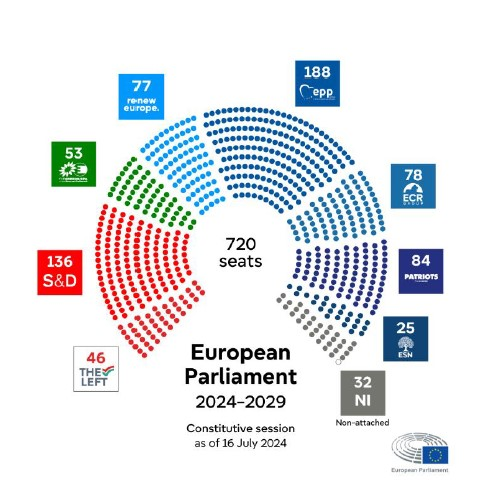

A list of all MEPs is obtained in Section 1, Task 1.

In [69]:
df_meps = pd.read_csv('meps.csv')
df_meps['person'] = df_meps['givenName'] + ' ' + df_meps['familyName']
df_meps

,identifier,id,familyName,givenName,political_group,person
0,257073,person/257073,Bocheński,Tobiasz,ECR,Tobiasz Bocheński
1,257256,person/257256,Kabilov,Taner,NI,Taner Kabilov
2,99945,person/99945,Düpont,Lena,PPE,Lena Düpont
3,204333,person/204333,De Meo,Salvatore,PPE,Salvatore De Meo
4,97236,person/97236,Toussaint,Marie,Verts/ALE,Marie Toussaint
...,...,...,...,...,...,...
714,197591,person/197591,Tinagli,Irene,S&D,Irene Tinagli
715,256937,person/256937,Costanzo,Vivien,S&D,Vivien Costanzo
716,256861,person/256861,Kollár,Kinga,PPE,Kinga Kollár
717,256877,person/256877,Piera,Pascale,PfE,Pascale Piera


For general descriptive statistics missing speeches are included as activity is still recorded. 

First, individual level of MEPs is taken into account to find top/bottom N members by activity. User can provide how many top/bottom members to be seen. Roberta Metsola and Christel Schaldemose as President and Vice President of EU Parliament respectively are skipped for a fair visualization of the top. The MEPs who never gave a speech are also included separately from the bottom. If members have the same number of speeches to enter top/bottom it is decided alphabetically by the first name.

How many top MEPs would you like to see? (e.g., 10, 20, 50):  15


                 person  count political_group    last_name
0       Roberta Metsola    368             PPE      Metsola
1  Christel Schaldemose    143             S&D  Schaldemose
                         person  count political_group  last_name
2                 João Oliveira    136        The Left   Oliveira
3                  Lukas Sieper    125              NI     Sieper
4                  Roberts Zīle    111             ECR       Zīle
5         Esteban González Pons    107             PPE   González
6               Sabine Verheyen    106             PPE   Verheyen
7           Sebastian Tynkkynen    105             ECR  Tynkkynen
8                 Martin Hojsík     97           Renew     Hojsík
9   Juan Fernando López Aguilar     89             S&D   Fernando
10                   Javi López     87             S&D      López
11              Victor Negrescu     85             S&D   Negrescu
12              Younous Omarjee     83        The Left    Omarjee
13            Nicolae Ştefăn

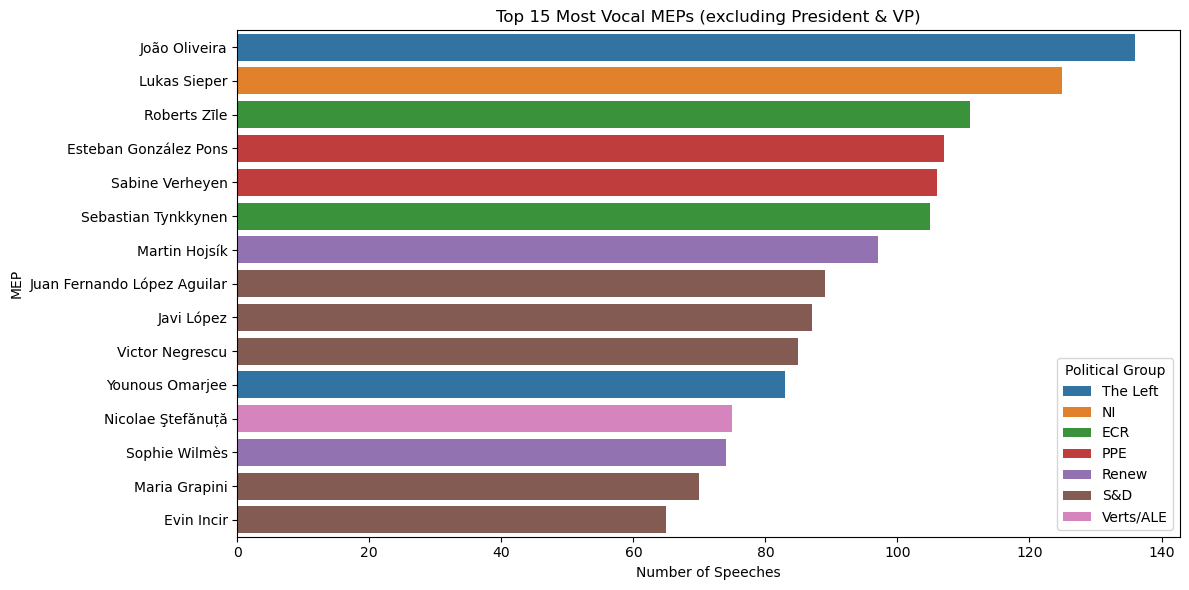

                   person  count political_group     last_name
696        Pascal Arimont      1             PPE       Arimont
688    Bartosz Arłukowicz      1             PPE    Arłukowicz
695          Sibylle Berg      1              NI          Berg
697         Stefan Berger      1             PPE        Berger
690           Rachel Blom      1             PfE          Blom
694           Borys Budka      1             PPE         Budka
698  Alma Ezcurra Almansa      1             PPE       Ezcurra
699       Martin Häusling      1       Verts/ALE      Häusling
693          Martine Kemp      1             PPE          Kemp
691          Norbert Lins      1             PPE          Lins
692   Fulvio Martusciello      1             PPE  Martusciello
700      Martin Sonneborn      1              NI     Sonneborn
689         Marianne Vind      1             S&D          Vind
687       Marion Walsmann      1             PPE      Walsmann
684         Damien Carême      2        The Left       

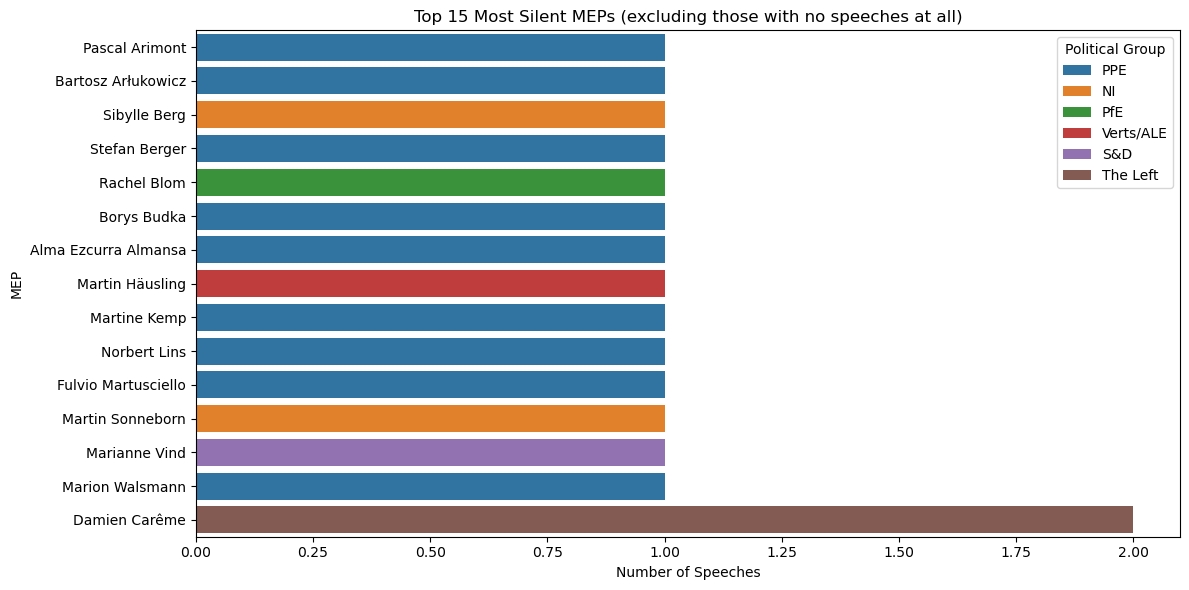

There are 18 current members of Parliament who did not give any speech. Their names and political groups are:

- Ondřej Kovařík (PfE)
- Stanisław Tyszka (ESN)
- Claudiu Manda (S&D)
- Giuseppe Milazzo (ECR)
- Volker Schnurrbusch (NI)
- Mircea-Gheorghe Hava (PPE)
- Ilia Lazarov (PPE)
- Gheorghe Cârciu (S&D)
- Sirpa Pietikäinen (PPE)
- Hanna Gronkiewicz-Waltz (PPE)
- Nadine Morano (PPE)
- Flavio Tosi (PPE)
- Iuliu Winkler (PPE)
- Galato Alexandraki (ECR)
- Dragoş Benea (S&D)
- Mihai Tudose (S&D)
- Waldemar Tomaszewski (ECR)
- Aldo Patriciello (PfE)


In [106]:
n_top = input("How many top MEPs would you like to see? (e.g., 10, 20, 50): ").strip()
try:
    n_top = int(n_top)
except ValueError:
    n_top = 20
all_counts = merged_df.groupby('person').size().sort_values(ascending=False).reset_index(name='count')
all_counts_pg = pd.merge(all_counts, df_meps[['person', 'political_group']], on='person', how='left')
all_counts_pg['last_name'] = all_counts_pg['person'].apply(lambda x: x.split()[1])

#exclude President and VP from Top 20
presidents = ['Roberta Metsola', 'Christel Schaldemose']
topN = (
    all_counts_pg[~all_counts_pg['person'].isin(presidents)]
    .head(n_top)
)

bottomN = (
    all_counts_pg[~all_counts_pg['person'].isin(presidents)]
    .sort_values(by=['count', 'last_name'], ascending=True)
    .head(n_top)
)

presidents_counts = (
    all_counts_pg[all_counts_pg['person'].isin(presidents)]
)
print(presidents_counts)
print(topN)
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='person', hue='political_group', data=topN, dodge=False)
plt.title(f'Top {n_top} Most Vocal MEPs (excluding President & VP)')
plt.xlabel('Number of Speeches')
plt.ylabel('MEP')
plt.legend(title='Political Group')
plt.tight_layout()
plt.show()
print(bottomN)
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='person', hue='political_group', data=bottomN, dodge=False)
plt.title(f'Top {n_top} Most Silent MEPs (excluding those with no speeches at all)')
plt.xlabel('Number of Speeches')
plt.ylabel('MEP')
plt.legend(title='Political Group')
plt.tight_layout()
plt.show()

zero_counts = pd.merge(df_meps[['person', 'political_group']], all_counts, on='person', how='left')
zero_counts['count'] = zero_counts['count'].fillna(0).astype(int)
zero_counts = zero_counts[zero_counts['count']==0]
print(f'There are {len(zero_counts)} current members of Parliament who did not give any speech. Their names and political groups are:\n')
for _, row in zero_counts.iterrows():
    print(f"- {row['person']} ({row['political_group']})")

Another level of speech analysis is a political group. 

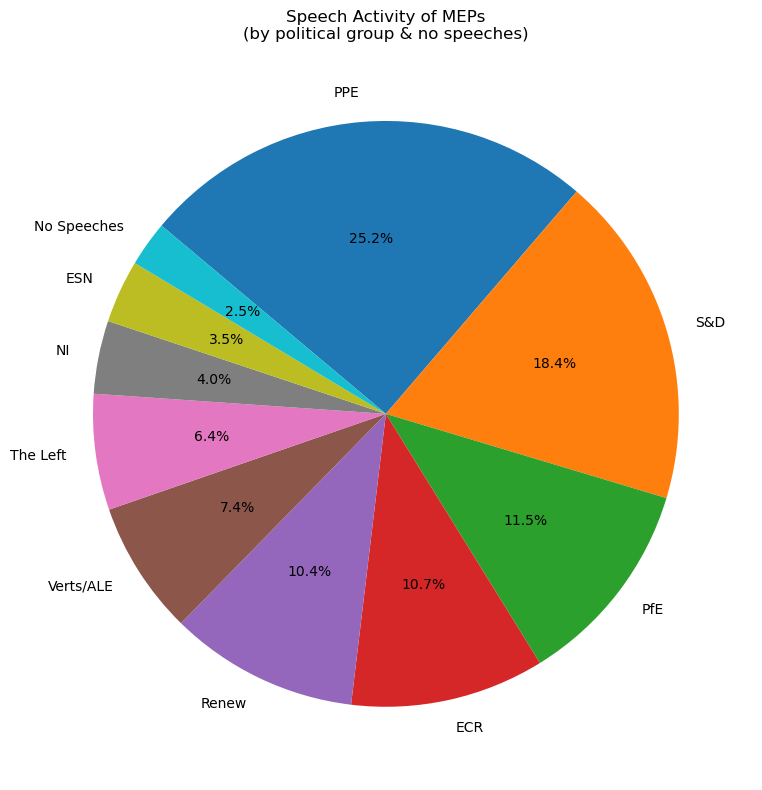

In [111]:
counts_party = pd.merge(
    df_meps[['person', 'political_group']],
    all_counts,
    on='person',
    how='left'
)
counts_party['count'] = counts_party['count'].fillna(0).astype(int)
spoken_df = counts_party[counts_party['count'] > 0]
silent_df = counts_party[counts_party['count'] == 0] 
spoken_counts = spoken_df['political_group'].value_counts().sort_values(ascending=False)
spoken_counts_with_silent = pd.concat([ #add those with no speeches as a separate category
    spoken_counts,
    pd.Series({'No Speeches': len(silent_df)})
])
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20.colors
plt.pie(
    spoken_counts_with_silent,
    labels=spoken_counts_with_silent.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
plt.title('Speech Activity of MEPs\n(by political group & no speeches)')
plt.tight_layout()
plt.show()

For text analysis missing speeches are excluded. 

In [216]:
merged_df = pd.read_csv('processed_speeches.csv')
merged_df_nona = merged_df[~pd.isna(merged_df['speech_text'])]
print(f'There are {len(merged_df_nona)} speeches for the analysis')

There are 10699 speeches for the analysis


The measure of a speech has to capture substance. It should be time-independent to use anytime. The idea is to create substantiveness score that will reflect how fact-based or argument-driven speech is. 

Substantiveness Score (scale 0 to 1):
- **Factual Density**: Count of numerical/statistical references (e.g. %, €, numbers). Tool - *regex*. Weight - *0.25*.
- **References Markers**: Presence of references. Tool - *predefined dictionary*. Weight - *0.20*.
- **Fluff words**: Absence of vague words ("great", "wonderful", "important", etc.). Tool - *predefined dictionary*. Weight - *0.20*.
- **Named entities**: Mentioning of specific people, organizations, locations, or dates. Tool - *predefined Spacy dictionary*. Weight - *0.10*.
- **Technical terms**: Use of EU-specific jargon. Tool - *predefined dictionary*. Weight - *0.10*.
- **Argumentative Markers**: Presence of logical connectors (e.g., "because", "therefore", "however", "evidence"). Tool - *predefined dictionary*. Weight - *0.075*.
- **Complexity**: Average sentence length (as a proxy for structured thought). Tool - *length calculation*. Weight - *0.075*.

Dictionaries are created with the help of ChatGPT4o using politics context. 

In [217]:
fluff_words = {
    "great", "important", "wonderful", "incredible", "amazing", "nice", "good", "fantastic", "huge", "tremendous",
    "brilliant", "perfect", "excellent", "awesome", "outstanding", "impressive", "significant", "unprecedented",
    "notable", "successful", "historic", "remarkable", "superb", "magnificent", "noteworthy", "terrific", "ideal",
    "positive", "world-class", "strong", "beautiful", "top", "premier", "leading", "celebrated", "ambitious", "bold",
    "proud", "vital", "essential", "visionary", "stellar", "innovative", "exciting", "groundbreaking"
}
argumentative_words = {
    "because", "therefore", "hence", "however", "evidence", "data", "according", "as a result", "suggest", "indicate",
    "demonstrate", "support", "conclude", "analysis", "study", "report", "statistics", "shown", "prove", "argue",
    "for example", "in fact", "indeed", "consequently", "furthermore", "moreover", "nevertheless", "nonetheless",
    "in contrast", "in addition", "on the other hand", "research", "examined", "reveals", "clearly", "justified",
    "correlation", "causal", "rationale", "logic", "reason", "objectively", "evidently", "empirical", "verifiable"
}
technical_terms = {
    "directive", "regulation", "treaty", "amendment", "compliance", "jurisdiction",
    "subsidy", "tariff", "legislation", "budget", "framework", "procedure",
    "competence", "resolution", "policy", "proposal", "governance", "institution"
}
reference_markers = {
    "according to", "report", "study", "source", "eurostat", "white paper", "oecd"
}
stop_words = set(stopwords.words('english'))

In [218]:
def count_proper_nouns(text): 
    try:
        blob = TextBlob(text)
        return sum(1 for word, tag in blob.tags if tag in ('NNP', 'NNPS')) #proper nouns using textblob
    except:
        return 0

In [219]:
def calculate_substantiveness(speech):
    if not isinstance(speech, str) or len(speech.strip()) == 0:
        return pd.Series([0]*7, index=[
            'factual', 'argumentative', 'complexity', 'fluff', 'named_entities', 'technical_terms', 'references'
        ])
    
    #sentence & word tokenization
    sentences = sent_tokenize(speech)
    words = word_tokenize(speech.lower())
    words_cleaned = [w for w in words if w.isalpha() and w not in stop_words]
    speech_lower = speech.lower()
    
    #1. Factual density
    factual_count = len(re.findall(r'\b\d+[\d\.,]*\b|\b€|\b%|\b\d{4}\b', speech)) #regex for numbers, percentages, currency symbols and years

    #2. Reference count
    reference_count = sum(1 for phrase in reference_markers if phrase in speech_lower) #check for referencing

    #3. Fluff density (inverted)
    fluff_count = sum(1 for w in words_cleaned if w in fluff_words) 

    #4. Named entities
    named_entities = count_proper_nouns(speech)

    #5. Technical jargon
    tech_term_count = sum(1 for w in words_cleaned if w in technical_terms)
    
    #6. Argumentative markers
    argument_count = sum(1 for w in words_cleaned if w in argumentative_words)
    
    #7. Complexity (avg sentence length)
    avg_sentence_length = np.mean([len(word_tokenize(s)) for s in sentences]) if sentences else 0
    

    return pd.Series([factual_count, argument_count, avg_sentence_length, fluff_count, named_entities, tech_term_count, reference_count], index=[
        'factual', 'argumentative', 'complexity', 'fluff',
        'named_entities', 'technical_terms', 'references'
    ])
merged_df_nona = merged_df_nona.copy()
#apply scoring
sub_df = merged_df_nona['speech_text'].apply(calculate_substantiveness)
sub_df.columns = ['factual', 'argumentative', 'complexity', 'fluff', 'named_entities', 'technical_terms', 'references']

for col in sub_df.columns:
    merged_df_nona.loc[:, col] = sub_df[col]
    
#normalize - in case new speeches appear the score will be updated
all_norm_cols = ['factual', 'argumentative', 'complexity', 'fluff', 'named_entities', 'technical_terms', 'references']
for col in all_norm_cols:
    if col != 'fluff':  #fluff is inverted later
        min_val = merged_df_nona[col].min()
        max_val = merged_df_nona[col].max()
        merged_df_nona.loc[:, col + '_norm'] = ((merged_df_nona[col] - min_val) / (max_val - min_val) if max_val != min_val else 0)
#invert fluff
min_fluff = merged_df_nona['fluff'].min()
max_fluff = merged_df_nona['fluff'].max()
merged_df_nona.loc[:, 'fluff_norm'] = 1 - ((merged_df_nona['fluff'] - min_fluff) / (max_fluff - min_fluff) if max_fluff != min_fluff else 1)

#final Substantiveness Score - with weigthing sum of importance
merged_df_nona.loc[:, 'substance_score'] = (
    0.25 * merged_df_nona['factual_norm'] +
    0.20 * merged_df_nona['references_norm'] +
    0.20 * merged_df_nona['fluff_norm'] +
    0.10 * merged_df_nona['named_entities_norm'] +
    0.10 * merged_df_nona['technical_terms_norm'] +
    0.075 * merged_df_nona['argumentative_norm'] +
    0.075 * merged_df_nona['complexity_norm']
)
merged_df_nona.to_csv('speeches_score.csv', index=False)


Substantiveness Score includes factual density, references count, usage of vague words, mentioning of named entities, technical jargon usage, argumentative markers and complexity measured by average sentence length. 
The higher the score is, the less 'air-talk' the speech has.



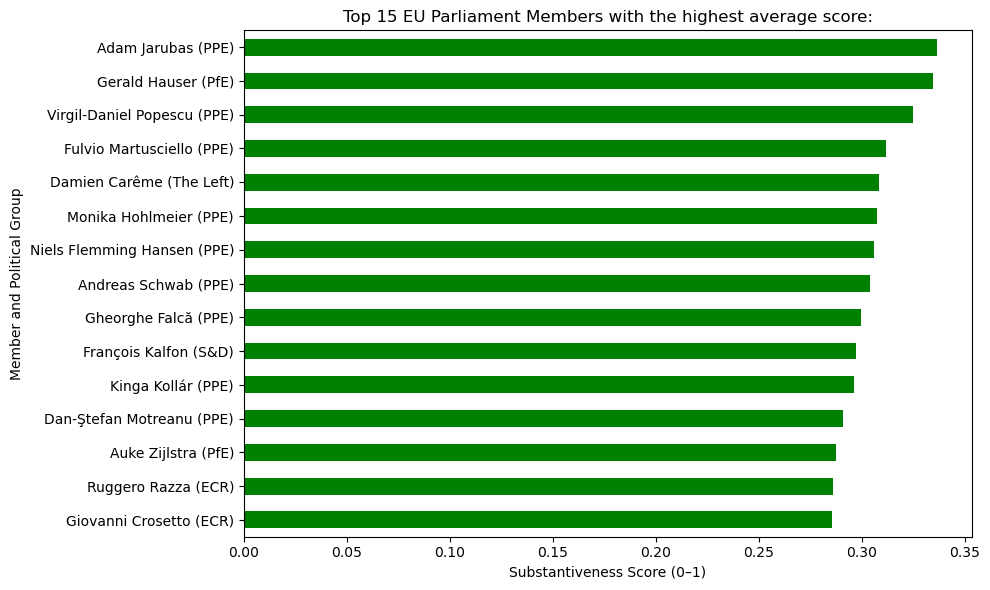

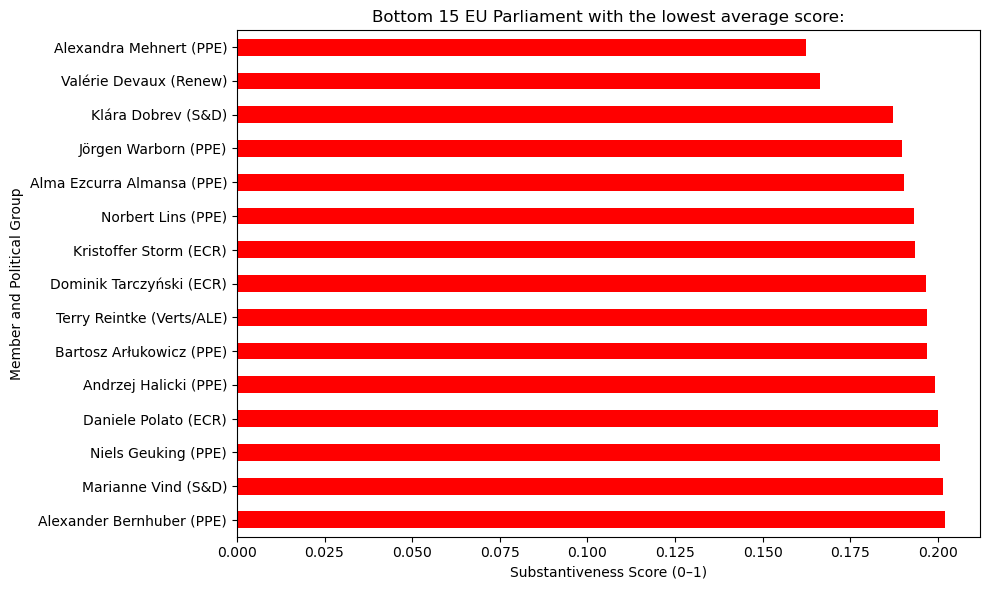

In [220]:
#average Substantiveness Score by a member 
merged_df_nona.loc[:, 'member_with_group'] = merged_df_nona['person'] + ' (' + merged_df_nona['political_group'] + ')'

member_scores = merged_df_nona.groupby('member_with_group')['substance_score'].mean().sort_values(ascending=False)

print('''
Substantiveness Score includes factual density, references count, usage of vague words, mentioning of named entities, technical jargon usage, argumentative markers and complexity measured by average sentence length. 
The higher the score is, the less 'air-talk' the speech has.
''')
#show top 15 members with the highest average Substantiveness Score (less 'air-talk')
plt.figure(figsize=(10, 6))
member_scores.head(15).plot(kind='barh', color='green')
plt.gca().invert_yaxis()
plt.title("Top 15 EU Parliament Members with the highest average score:")
plt.xlabel("Substantiveness Score (0–1)")
plt.ylabel("Member and Political Group")
plt.tight_layout()
plt.show()

#show bottom 15 (most air-talk)
plt.figure(figsize=(10, 6))
member_scores.tail(15).plot(kind='barh', color='red')
plt.gca()
plt.title("Bottom 15 EU Parliament with the lowest average score:")
plt.xlabel("Substantiveness Score (0–1)")
plt.ylabel("Member and Political Group")
plt.tight_layout()
plt.show()

In [221]:
#example of a substantial speech
merged_df_nona[merged_df_nona['person']=='Adam Jarubas']

,date,topic,person,person_id,political_group,activity_id,speech_text,factual,argumentative,complexity,...,references,factual_norm,argumentative_norm,complexity_norm,named_entities_norm,technical_terms_norm,references_norm,fluff_norm,substance_score,member_with_group
2523,2024-10-10,World Mental Health Day - need for a comprehen...,Adam Jarubas,197517,PPE,MTG-PL-2024-10-10-OTH-2017002582311,"Mr President, thank you very much. Mr. Commiss...",4.0,3.0,23.375000,...,1.0,0.137931,0.250000,0.151786,0.121053,0.000000,0.25,0.750000,0.276722,Adam Jarubas (PPE)
3395,2024-10-23,Tackling the steel crisis: boosting competitiv...,Adam Jarubas,197517,PPE,MTG-PL-2024-10-23-OTH-2017003464344,"Madam President, thank you very much. Ladies a...",1.0,1.0,19.083333,...,1.0,0.034483,0.083333,0.123918,0.063158,0.071429,0.25,0.916667,0.270957,Adam Jarubas (PPE)
8066,2025-02-11,The need to address urgent labour shortages an...,Adam Jarubas,197517,PPE,MTG-PL-2025-02-11-OTH-2017014850443,"Mr President, thank you very much. Commissione...",7.0,5.0,17.888889,...,4.0,0.241379,0.416667,0.116162,0.115789,0.071429,1.00,1.000000,0.519029,Adam Jarubas (PPE)
8808,2025-02-12,Silent crisis: the mental health of Europe’s y...,Adam Jarubas,197517,PPE,MTG-PL-2025-02-12-OTH-2017015183853,"Mr President, thank you very much. Mr. Commiss...",3.0,2.0,25.181818,...,1.0,0.103448,0.166667,0.163518,0.084211,0.000000,0.25,0.750000,0.259047,Adam Jarubas (PPE)
9400,2025-03-11,Presentation of the proposal on Critical Medic...,Adam Jarubas,197517,PPE,MTG-PL-2025-03-11-OTH-2017017665291,"Madam President, thank you very much. Mr. Comm...",4.0,2.0,22.384615,...,1.0,0.137931,0.166667,0.145355,0.142105,0.071429,0.25,0.916667,0.312571,Adam Jarubas (PPE)
11358,2025-04-02,European Steel and Metals Action Plan (debate),Adam Jarubas,197517,PPE,MTG-PL-2025-04-02-OTH-2017020467539,"Madam President, thank you very much. Mr. Comm...",0.0,2.0,23.818182,...,2.0,0.000000,0.166667,0.154664,0.078947,0.000000,0.50,1.000000,0.331995,Adam Jarubas (PPE)
11509,2025-04-03,European Action Plan on Rare Diseases (debate),Adam Jarubas,197517,PPE,MTG-PL-2025-04-03-OTH-2017020625703,"Mr President, thank you very much. Mr. Commiss...",8.0,5.0,17.470588,...,1.0,0.275862,0.416667,0.113445,0.115789,0.142857,0.25,1.000000,0.384589,Adam Jarubas (PPE)


In [222]:
print(merged_df_nona[merged_df_nona['person']=='Adam Jarubas'].iloc[2]['speech_text'])

Mr President, thank you very much. Commissioner, I'm sorry. Already in her 2023 State of the Union address, the President of the European Commission drew attention to the record millions of vacancies in the Union, economic losses, unfulfilled services. In health care, it is often literally a matter of life and death. According to the OECD, there is a shortage of 200 000 workers in the EU. According to WHO, 40% of doctors will retire in the next five years.
The COVID pandemic has put older workers at particular risk. Subsequent waves overburdened, traumatized, burned out professionally, increasing the transition to early retirement or leaving the profession. It puts more pressure on the others. And the wheel closes. For example, in oncology, 77% of people work overtime, and more than half complain about overload and bureaucracy.
We need to make more use of digitalisation, support artificial intelligence and increase efficiency in a safe way. We need to educate more medical staff and doc

In [223]:
#example of a less substantial speech
merged_df_nona[merged_df_nona['person']=='Alexandra Mehnert']

,date,topic,person,person_id,political_group,activity_id,speech_text,factual,argumentative,complexity,...,references,factual_norm,argumentative_norm,complexity_norm,named_entities_norm,technical_terms_norm,references_norm,fluff_norm,substance_score,member_with_group
10053,2025-03-12,Action Plan for the Automotive Industry (debate),Alexandra Mehnert,256980,PPE,MTG-PL-2025-03-12-OTH-2017017882453,"Madam President, ladies and gentlemen! The Eur...",0.0,2.0,23.3,...,0.0,0.0,0.166667,0.151299,0.052632,0.0,0.0,0.666667,0.162444,Alexandra Mehnert (PPE)


In [224]:
print(merged_df_nona[merged_df_nona['person']=='Alexandra Mehnert'].iloc[0]['speech_text'])

Madam President, ladies and gentlemen! The European Commission has presented a good action plan to strengthen the competitiveness of the European automotive industry. The action plan is also important for my home country of Saxony-Anhalt – on the one hand from the point of view of motorists, because the car is indispensable, especially in rural areas, but on the other hand also from the point of view of the automotive industry, which creates good jobs with its proximity to Wolfsburg, also in Saxony-Anhalt.
This action plan offers opportunities for job creation and investment in sustainable technologies, but also for the preservation of existing structures. We particularly support the promotion of battery production within the EU, which will also create jobs in rural areas.
Equally important is support for the development of skilled workers. Particularly in rural regions, we must exploit the existing potential and successfully shape a competitive and sustainable economy through targeted

### Manual dashboard - ipywidgets do not work in my Jupyter Notebook

The benefit of the transparent score is that a user can also find information about components. 

In [225]:
# === Choose your settings here ===
selected_metric = 'references'   #'factual', 'argumentative', 'complexity', 'fluff', 'named_entities', 'technical_terms', 'references', 'substance_score'
rank_type = 'top'           #'top' or 'bottom'
n_members = 15              #how many to show

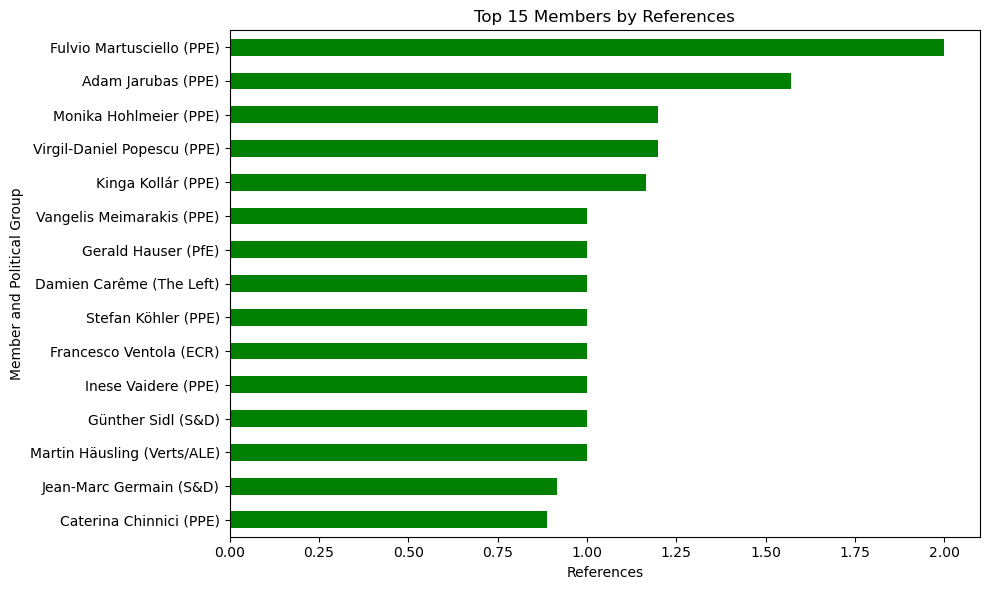

In [226]:
metric_column = selected_metric if selected_metric == 'substance_score' else selected_metric + '_norm' #use normalized column

#group by member and average the selected metric
ascending_order = True if rank_type == 'bottom' else False

grouped = merged_df_nona.groupby('member_with_group')[selected_metric].mean()
grouped = grouped.sort_values(ascending=ascending_order)

#select top or bottom N
selected_data = grouped.head(n_members)

#plot
plt.figure(figsize=(10, 6))
color = 'green' if rank_type == 'top' else 'red'
selected_data.plot(kind='barh', color=color)
plt.gca().invert_yaxis()
plt.title(f"{rank_type.title()} {n_members} Members by {selected_metric.replace('_', ' ').title()}")
plt.xlabel(selected_metric.replace('_', ' ').title())
plt.ylabel('Member and Political Group')
plt.tight_layout()
plt.show()

### Political group level

Same logic can be applied at the whole political group level. 

In [227]:
# === Choose your settings here ===
selected_metric = 'substance_score'   #'factual', 'argumentative', 'complexity', 'fluff', 'named_entities', 'technical_terms', 'references', 'substance_score'
rank_type = 'top'           #'top' or 'bottom'


Substantiveness Score includes factual density, references count, usage of vague words, mentioning of named entities, technical jargon usage, argumentative markers and complexity measured by average sentence length. 
The higher the score is, the less 'air-talk' the speech has.



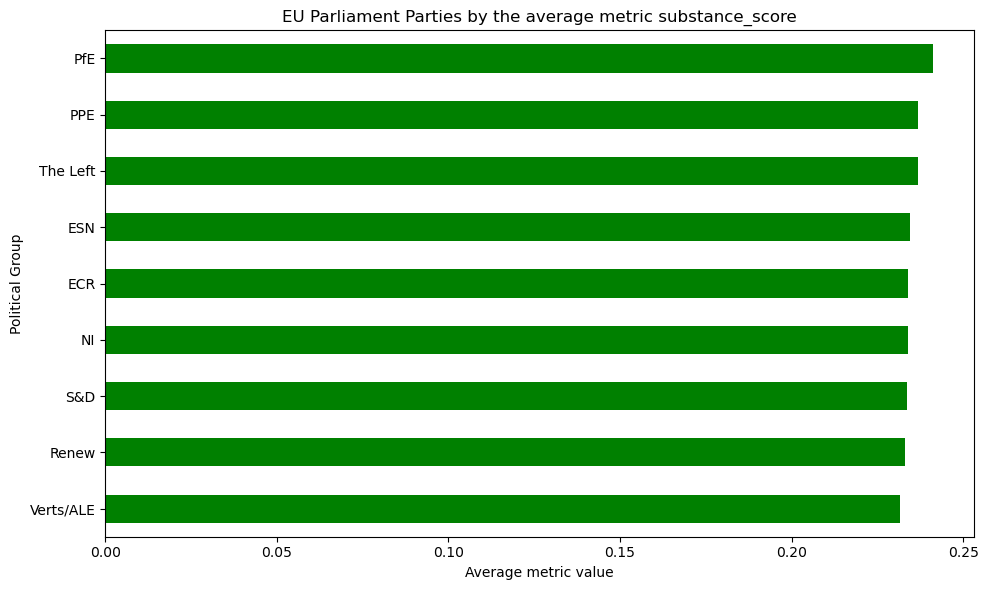

In [228]:
metric_column = selected_metric if selected_metric == 'substance_score' else selected_metric + '_norm' #use normalized column

#group by member and average the selected metric
ascending_order = True if rank_type == 'bottom' else False

grouped = merged_df_nona.groupby('political_group')[selected_metric].mean()
grouped = grouped.sort_values(ascending=ascending_order)

print('''
Substantiveness Score includes factual density, references count, usage of vague words, mentioning of named entities, technical jargon usage, argumentative markers and complexity measured by average sentence length. 
The higher the score is, the less 'air-talk' the speech has.
''')

plt.figure(figsize=(10, 6))
color = 'green' if rank_type == 'top' else 'red'
grouped.plot(kind='barh', color=color)
plt.gca().invert_yaxis()
plt.title(f"EU Parliament Parties by the average metric {selected_metric}")
plt.xlabel("Average metric value")
plt.ylabel("Political Group")
plt.tight_layout()
plt.show()